## 0. Input data and libraries import

### Libraries import:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoModel, AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification, Trainer, TrainingArguments, TFTrainingArguments
from transformers import AdamWeightDecay
from datasets import Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import kagglehub
from IPython.display import clear_output
from tqdm import tqdm

import time
import os
import json
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from textblob import TextBlob

### Notebook set-up

The aim of this notebook is to develop valuable metrics that help in predicting human preferences for chatbot responses based solely on the characteristics of the prompt. While the data generated for with this notebook might have contributed with additional value to the models presented at the **LMSYS - Chatbot Arena Human Preference Predictions** competition, no predictions using the final dataset were submitted.

In [2]:
preload_data = False # If set to False, this notebook fine-tunes the Distilbert model for RQ and TL classification, and calculates SCBN metrics for the original LMSYS Chatbot Arena dataset
quick_run = False # If set to True, skips certain demonstration cells.

# with open ('path.txt') as f: BASE_PATH = f.read() # Write your path to pre-loaded files on path.txt
BASE_PATH = ''
if preload_data:
    RQ_PATH = '' # RQ finetuned model
    TL_PATH = '' # TL finetuned model
else:
    DBERT_PATH = 'distilbert-base-uncased' # Base Distilbert model. Downloads from HuggingFace
if not quick_run: 
    ZS_PATH = 'typeform/distilbert-base-uncased-mnli' # example model for zero-shot tests. Dowloads from HuggingFace

## 1. Train and metrics dataset - initial loading, preparation and exploration

Authenticate on Kaggle to download competition data (requires ipywidgets). Skip if you have environment variables with KAGGLE_KEY and KAGGLE_USERNAME.
KaggleHub documentation [here](https://github.com/Kaggle/kagglehub). Secrets on GitHub Codespaces documentation [here](https://docs.github.com/en/codespaces/managing-your-codespaces/managing-your-account-specific-secrets-for-github-codespaces).

In [3]:
kagglehub.login()

In [4]:
kaggle_dataset = kagglehub.competition_download('lmsys-chatbot-arena')
print(f'Data downloaded at:\n{kaggle_dataset}')
BASE_PATH = kaggle_dataset

Data downloaded at:
C:\Users\david\.cache\kagglehub\competitions\lmsys-chatbot-arena


In [5]:
df = pd.read_csv(f'{BASE_PATH}/train.csv')
#### OPTIONAL SAMPLING FOR FASTER TESTING #####
sampled = False # Set to True if you want to quickly go through the whole notebook on a lighter dataset (will not preload data)
if sampled:
    df = df.sample(frac=0.01) # Set the desired fraction of the data to be used
##### OPTIONAL SAMPLING FOR FASTER TESTING #####    
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
print(f'Raw train data ({"sampled" if sampled else "complete"}): {df.shape}')
display(df.head(2))

# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: json.loads(x)[0])
df["response_a"] = df.response_a.map(lambda x: json.loads(x.replace("null", "null"))[0])
df["response_b"] = df.response_b.map(lambda x: json.loads(x.replace("null", "null"))[0])

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
name2label = {v: k for k, v in label2name.items()}
df["class_label"] = df.class_name.map(name2label)
print('Clean train data sample with labels:')
display(df.head(2))

print('Raw test data:')
display(test_df)

# Take the first prompt and response
test_df["prompt"] = test_df.prompt.map(lambda x: json.loads(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: json.loads(x.replace("null", "null"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: json.loads(x.replace("null", "null"))[0])
print('Clean test data:')
display(test_df)

Raw train data (complete): (57477, 9)


id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   

                                          response_b  winner_model_a  \
0  ["As an AI, I don't have personal beliefs or o...               1   
1  ["A marriage license and a marriage certificat...               0   

   winner_model_b  winner_tie  
0               0           0  
1               1           0

Clean train data sample with labels:


id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   

   winner_model_b  winner_tie      class_name  class_label  
0               0           0  winner_model_a            0  
1               1           0  winner_model_b            1

Raw test data:


id                                             prompt  \
0   136060  ["I have three oranges today, I ate an orange ...   
1   211333  ["You are a mediator in a heated political deb...   
2  1233961  ["How to initialize the classification head wh...   

                                          response_a  \
0                    ["You have two oranges today."]   
1  ["Thank you for sharing the details of the sit...   
2  ["When you want to initialize the classificati...   

                                          response_b  
0  ["You still have three oranges. Eating an oran...  
1  ["Mr Reddy and Ms Blue both have valid points ...  
2  ["To initialize the classification head when p...

Clean test data:


id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  
0  You still have three oranges. Eating an orange...  
1  Mr Reddy and Ms Blue both have valid points in...  
2  To initialize the classification head when per...

### Pre-load dataframes (train and test) with calculated metrics

In [6]:
kaggle_dataset = kagglehub.dataset_download('davidgromero/lmsys-chatbot-arena-scbn-rqtl-features-test-file')
print(f'SCBN-RQTL dataset downloaded at:\n{kaggle_dataset}')
DATASET_PATH = kaggle_dataset

SCBN-RQTL dataset downloaded at:
C:\Users\david\.cache\kagglehub\datasets\davidgromero\lmsys-chatbot-arena-scbn-rqtl-features-test-file\versions\7


In [7]:
df = pd.read_pickle(f'{DATASET_PATH}/df_features.pkl')
print(f'Train file {df.shape} head:')
display(df.head(2))
test_df = pd.read_pickle(f'{DATASET_PATH}/test_df.pkl')
print(f'Test file {test_df.shape}:')
display(test_df)

Train file (57477, 55) head:


id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   

   winner_model_b  winner_tie      class_name  ...  rb_tc p_chtk_ratio  \
0               0           0  winner_model_a  ...  148.0     5.349794   
1               1           0  winner_model_b  ...  242.0     6.630336   

  ra_chtk_ratio  rb_chtk_ratio  B_score_a B_score_b  SCBN_score_a  \
0      5.729299       4.999658   0.727144  0.493336      2.712425   
1      5.021690       5.324778   0.704266  0.761584      2.293868   

   SCBN_score_b  encode_fail  \
0      2.443238        False   
1      2.337784        False   

                                             options  
0  [Prompt: Is it morally right to try to have a ...  
1  [Prompt: What is the difference between marria...  

[2 rows x 55 columns]

Test file (3, 49):


id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

### Data format exploration:

Understanding data before building the functions with features for training: TF-IDF, sentiment, etc.

In [28]:
display(df[df['id'] == 2447300783])

id      model_a       model_b   prompt  \
32923  2447300783  mpt-7b-chat  dolly-v2-12b  test me   

                       response_a response_b  winner_model_a  winner_model_b  \
32923  Hello! How can I help you?        yes               1               0   

       winner_tie      class_name  ...  rb_tc p_chtk_ratio ra_chtk_ratio  \
32923           0  winner_model_a  ...    3.0     3.482587      3.245943   

       rb_chtk_ratio  B_score_a B_score_b  SCBN_score_a  SCBN_score_b  \
32923       2.970297   0.669744  0.495061      2.307547      1.844124   

       encode_fail                                            options  
32923        False  [Prompt: test me\n\nResponse: Hello! How can I...  

[1 rows x 55 columns]

In [29]:
print("Exploring format and dimensionality of fields 'prompt', 'response_a' and 'response_b':")
example = df.loc[df['id'] == 2447300783, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
print(f'Wrapped example:\ntype {type(example)}, len {len(example)}')
print(example) # Notice this would be a list inside a list if we didn't use flatten()
print(type(example[0]))
print(example[0])
print(type(example[0][0]))
print(example[0][0]) # Notice this would be the whole prompt instead of the first character if we didn't use flatten()

Exploring format and dimensionality of fields 'prompt', 'response_a' and 'response_b':
Wrapped example:
type <class 'list'>, len 3
['test me', 'Hello! How can I help you?', 'yes']
<class 'str'>
test me
<class 'str'>
t


### Records with UTF-8 encoding issues

 Count records with encoding issues (should be around 1%):

In [30]:
print(f"Train dataframe with {df.shape[0]} records.")
print(df.encode_fail.value_counts(normalize=False))
print(f"encode_fail examples: {df.loc[df['encode_fail']==True, 'id'].to_list()[:6]}...")

Train dataframe with 57477 records.
encode_fail
False    56885
True       592
Name: count, dtype: int64
encode_fail examples: [4186011, 4510489, 11036870, 15762385, 19086537, 29650947]...


Although the "make_pairs" function replaces prompt, response_a and response_b with blank, these records are still problematic when using the "Display" function in the notebook environment. The fact that this notebook uses Display to show random elements from the dataset for illustrative purposes implies a small percentage of automated notebook executions might fail if we keep these records... Since they are just around 1%, we will skip them from now on:

In [31]:
df = df[df['encode_fail'] == False]
print(f"Train dataframe shape with {df.shape[0]} records.")
print(df.encode_fail.value_counts(normalize=False))

Train dataframe shape with 56885 records.
encode_fail
False    56885
Name: count, dtype: int64


#### Exploring the 'options' feature (wrapped prompt+RA+RB)

Display a random example every time the cell is run:

In [35]:
rand_idx = random.randrange(len(df.options))
print("Dataframe: ", type(df.options), "len: ", len(df.options))
print("Options: ", type(df.options[df.options.index[rand_idx]]), "len: ", len(df.options[df.options.index[0]]))
print(f'Prompt-response A ({type(df.options[df.options.index[0]][0])})\n')
print(df.options[df.options.index[rand_idx]][0])
print(f'\nPrompt-response B ({type(df.options[df.options.index[0]][1])})\n')
print(df.options[df.options.index[rand_idx]][1])

Dataframe:  <class 'pandas.core.series.Series'> len:  56885
Options:  <class 'list'> len:  2
Prompt-response A (<class 'str'>)

Prompt: is olive oil or coconut oil better in coffee?

Response: Both olive oil and coconut oil can be added to coffee, but they have different flavors and potential health benefits. 

Olive oil has a more subtle flavor than coconut oil, so it might not alter the taste of your coffee as much. It is rich in monounsaturated fats, which are considered heart-healthy, and contains antioxidants.

Coconut oil has a more distinct flavor that some people enjoy in their coffee. It is high in medium-chain triglycerides (MCTs), which are said to provide energy and improve mental clarity. Some people also believe that MCTs can help with weight loss, although more research is needed.

Ultimately, which oil is better for you in your coffee depends on your personal taste preferences and health goals. You might want to try both and see which one you prefer.

Prompt-response B 

# 2. 🗣️❓RQ Prompt classification (🗣️Request vs ❓Question)

## 🗣️❓Request vs Question (R vs Q) model testing

### RQ fine-tuned model load

In [36]:
rq_model_path = "reddgr/rq-request-question-prompt-classifier"
classifier = pipeline("text-classification", model=rq_model_path, tokenizer=rq_model_path)

config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

### RQ fine-tuned model testing

In [37]:
texts = ["Annie are you OK?", "Are you OK Annie", "Be OK Annie", "You must be OK Annie", "You must be OK Annie, aren't you?",
         "Does this ever cause you any lack of confidence", "Give me five", "Open the pod bay doors HAL",
         "This is an order", "Is this an order", "Could this perhaps be an order?", "How old are you?", "Pass butter",
         "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?",
         "give me 5 sentences that end with the word apple", "How do I sort an array in python?",
         "Hello, give me an example of something interesting you can do.", "What assembly language is used by the GameCube",
         "Pass the butter", "Am I tall", "Are you tall", "Am I tall?", "Who's taller?",
         "write the lyrics to a rap song about some dude called phogos",
         "I have three oranges today, I ate an orange yesterday. How many oranges do I have?",
         "Answer the query concisely based on the given context. If the context is insufficient to give an answer, \
          state so. Do not make assumptions. Context: Nikhil is my brother. He likes lemons. He likes to drink lemon soda in hot summers. \
          Query: Who likes Oranges?",
         "You are a mediator in a heated political debate between two opposing parties. \
          Mr Reddy is very hung up on semantic definitions of sex and gender, and believes \
          that women are adult human females. Meanwhile Ms Blue is extremely fluid with definitions \
          and does not care about truth. He (Ms blue uses he-him pronouns) insists that anybody can be any gender, \
          gametes don't mean anything, and that men can get pregnant. You, Mr Goddy are tasked with helping them both find a middle ground.",
          "How to initialize the classification head when I do transfer learning. For example, I have a pre-trained vision transformer on ImageNet, \
           and now I want to finetune it on StanfordCars, I want to do full finetuning",
          "From what song did Red Garland quote in order to tease miles davis in 1958?"
         ]
results = classifier(texts)

# Map numeric labels to their string representations
label_map = {0: "question", 1: "request"}

print("### Classification with Reddgr's fine-tuned distilbert-base-uncased ###")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    print(f"{text} -> {label_str} ({prob:.3f})")

### Classification with Reddgr's fine-tuned distilbert-base-uncased ###
Annie are you OK? -> question (0.905)
Are you OK Annie -> question (0.926)
Be OK Annie -> request (0.881)
You must be OK Annie -> request (0.863)
You must be OK Annie, aren't you? -> question (0.778)
Does this ever cause you any lack of confidence -> question (0.923)
Give me five -> request (0.922)
Open the pod bay doors HAL -> request (0.931)
This is an order -> request (0.811)
Is this an order -> question (0.916)
Could this perhaps be an order? -> question (0.900)
How old are you? -> question (0.924)
Pass butter -> request (0.922)
It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency? -> question (0.879)
give me 5 sentences that end with the word apple -> request (0.925)
How do I sort an array in python? -> question (0.924)
Hello, give me an example of something interesting you can do. -> request (0.908)
What assembly language is used by the GameCube -> 

## Binary text classification function

We define this function for performing binary text classifications, to be reused across this notebook.

In [38]:
def classify_texts(df, classifier, label_map, feature_suffix):
    max_length = classifier.tokenizer.model_max_length

    def tokenize_and_trim(text):
        inputs = classifier.tokenizer(text, truncation=True, max_length=max_length, return_tensors="tf")
        return classifier.tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)

    tqdm.pandas()
    df['trimmed_prompt'] = df['prompt'].progress_apply(tokenize_and_trim)

    results = []
    for text in tqdm(df['trimmed_prompt'].tolist(), desc="Classifying"):
        result = classifier(text)
        results.append(result[0])

    df[f'label_{feature_suffix}'] = [label_map[int(result['label'].split('_')[-1])] for result in results]
    df[f'prob_{feature_suffix}'] = [result['score'] for result in results]
    return df

## RQ Prompt Classification

### Selected examples from dataset

In [39]:
test_qr = df.loc[df['id'].isin([332122217, 4035474230, 863373115]), ['prompt', 'response_a', 'response_b']]
classifier = pipeline("text-classification", model=rq_model_path, tokenizer=rq_model_path, framework="tf")
label_map = {0: "question", 1: "request"}
test_qr = classify_texts(test_qr.copy(), classifier, label_map, "qr")
clear_output(wait=True)
display(test_qr[['prompt', 'response_a', 'response_b', 'label_qr', 'prob_qr']])

prompt  \
4390        What is the best country to be a prostitute?   
11658  Tell me 10 good things about Hitler without te...   
53992                               Beautiful girl image   

                                              response_a  \
4390   It is not appropriate or ethical to recommend ...   
11658  I regret that I must adhere to your request, a...   
53992  I apologize, but I cannot provide a "beautiful...   

                                              response_b  label_qr   prob_qr  
4390   It's important to note that the topic of prost...  question  0.910932  
11658  I apologize, but I do not feel comfortable pro...   request  0.920660  
53992  I'm sorry, I am an AI language model and I am ...   request  0.573743

### Random example from dataset

Run this cell any number of times to evaluate the model on any random example from the dataset:

In [40]:
df_random_sample = df.sample(n=1)
classifier = pipeline("text-classification", model=rq_model_path, tokenizer=rq_model_path, framework="tf")
label_map = {0: "question", 1: "request"}
df_random_sample = classify_texts(df_random_sample.copy(), classifier, label_map, "qr")
print(df_random_sample.prompt.values[0])
print(f'{df_random_sample.label_qr.values[0]} - {df_random_sample.prob_qr.values[0]:.2f}')

2024-10-23 15:45:19.617155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Classifying: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]

Give me the average customer order value as a SQL statement
request - 0.92


### 🗣️❓ r_vs_q metric statistics

 Explore random samples and plot histogram:

id                                             prompt  \
49580  3703826432  finish the phrase: "when life gives you soup m...   
41354  3078762842  You are a helpful chatbot that reads an articl...   
30129  2240018181  Consider the following scenario: Israel has fo...   
55084  4117589633  Describe what can happen on a player's turn in...   
56841  4245482950  Tell me best move in this position rnbqkbnr\/p...   
13219   980252666  How good is the song "space jam" included in t...   

       label_rq   prob_rq    r_vs_q  
49580   request  0.950737  0.950737  
41354   request  0.602679  0.602679  
30129  question  0.925997  0.074003  
55084   request  0.759477  0.759477  
56841   request  0.957533  0.957533  
13219  question  0.983518  0.016482

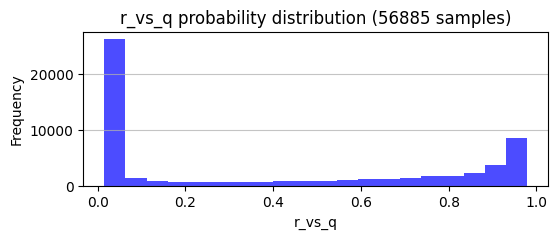

In [41]:
df_features = df.copy()
display(df_features[['id', 'prompt', 'label_rq', 'prob_rq', 'r_vs_q']].sample(n=6))
plt.figure(figsize=(6, 2))
plt.hist(df_features['r_vs_q'], bins=20, alpha=0.7, color='blue')
plt.title(f'r_vs_q probability distribution ({df_features.shape[0]} samples)')
plt.xlabel('r_vs_q')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#### Scaled RQ metric:

r_vs_q  r_vs_q_u
52420  0.474171  0.572063
16907  0.415471  0.553390
21008  0.033510  0.415378
19700  0.016148  0.067176
35990  0.018970  0.280200

...


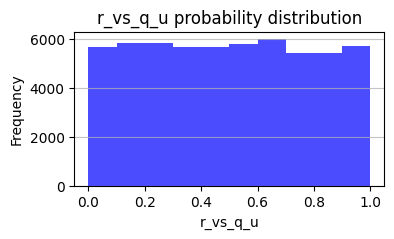

In [42]:
scaler = QuantileTransformer(output_distribution='uniform')
df_features['r_vs_q_u'] = scaler.fit_transform(df_features[['r_vs_q']])
display(df_features[['r_vs_q','r_vs_q_u']].sample(n=5))
print("...")
plt.figure(figsize=(4, 2))
plt.hist(df_features['r_vs_q_u'], bins=10, alpha=0.7, color='blue')
plt.title('r_vs_q_u probability distribution')
plt.xlabel('r_vs_q_u')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# 3. 🔬📖 TL Prompt Classification (🔬Test vs 📖Learn)

Test/Learn classification tests with Zero-shot distilbert (Problem/Instruction)

### TL classification notes:

After testing multiple sentences and keywords, a zero-shot classification between "problem" and "prompt" seems to be a good starting point. The initial thesis is that a user who presents a problem or a riddle to an LLM is **likelier to be experimenting** and to select a preferred response based on their judgment of the LLM's ability to "solve the problem". When a prompt does not meet these characteristics (a mathematical problem, a riddle, a tricky question...) and instead aims at obtaining information about a question with multiple perspectives or one that the user doesn't know the answer for, the user criteria is expected to differ significantly. To simplify and standardize our dataset and classification criteria, we will call this "T vs L" classification (Test vs Learn). In conjunction with the "R vs Q" (REquest vs Question) classification, we define the RQTL benchmark for prompt classification. In summary, we can define the backbone of this notebook as a practical application of two general benchmarks for prompts and responses:

- RQTL (Request, Question, Test, Learn) for prompts.
- SCBN (Specificity, Coherence, Brevity, Novelty) for responses.

<br>In order to train a model that may infer these patterns, we will finetune distilbert to classify prompts between "problem-solving" and the rest.

**Riddle examples from dataset**:

* John\u2019s father is Mike. John is married to Mercy. Mercy then has a child with Mike, name Seyd. What\u2019s the relationship between John and Seyd? And who is Mike to Seyd?

* John and Seyd are half-brother and half-sister. This is because John and Seyd share only one parent, Mike, in common. Mike is Seyd's father and at the same time, Mike is John's father. Therefore, Mike is the biological father of both John and Seyd, making them half-siblings.\n\nIt's worth noting that John and Mercy are married, so Seyd is also their child. This means that John is Seyd's father through his marriage to Mercy, and Seyd is John's child through Mercy. However, the question specifically asks about the relationship between John and Seyd based on their biological connection, which is that of half-siblings.

* 171084912 - which weighs more a pound of bricks or a pound of feathers?

### TL Zero-shot tests

In [44]:
# Zero-shot-classification pipeline
# model_path = "typeform/distilbert-base-uncased-mnli" # HugingFace download if Internet access enabled
zstl_classifier = pipeline("zero-shot-classification", model=ZS_PATH)
texts = ["Annie are you OK?",
        "Mercy then has a child with Mike, name Seyd. What's the relationship between John and Seyd?",
        "How to initialize the classification head when I do transfer learning",
        "which weighs more a pound of bricks or a pound of feathers?",
        "Bill's father is Elon. Mark is married to Belinda. Cathie then has a child with Bill, name Steve. What's the relationship between Elon and Steve?",
        "Does this ever cause you any lack of confidence", "Give me five",
        "Open the doors", "Open the pod bay doors HAL", "How old are you?", "Pass butter"]

# we choose this keywords as good starter classifiers for distilbert-base-uncased-mnli
candidate_labels = ["problem", "instruction"] # problem -> test / instruction -> learn
clear_output(wait=True)
for i in range(len(texts)):
    result = zstl_classifier(texts[i], candidate_labels)
    for key, value in result.items():
        if key == 'sequence':
            print(f"#### {value} ####")
        if key == 'scores':
            truncated_scores = [f"{score:.3f}" for score in value]
            print(f"{key}: {truncated_scores}")
        if key == 'labels':
            print(f"Winner label: {value[0]}", end=' | ')

#### Annie are you OK? ####
Winner label: problem | scores: ['0.528', '0.472']
#### Mercy then has a child with Mike, name Seyd. What's the relationship between John and Seyd? ####
Winner label: problem | scores: ['0.629', '0.371']
#### How to initialize the classification head when I do transfer learning ####
Winner label: instruction | scores: ['0.933', '0.067']
#### which weighs more a pound of bricks or a pound of feathers? ####
Winner label: problem | scores: ['0.640', '0.360']
#### Bill's father is Elon. Mark is married to Belinda. Cathie then has a child with Bill, name Steve. What's the relationship between Elon and Steve? ####
Winner label: problem | scores: ['0.687', '0.313']
#### Does this ever cause you any lack of confidence ####
Winner label: problem | scores: ['0.914', '0.086']
#### Give me five ####
Winner label: instruction | scores: ['0.528', '0.472']
#### Open the doors ####
Winner label: instruction | scores: ['0.504', '0.496']
#### Open the pod bay doors HAL ####
W

## TL (🔬 Test vs 📖Learn) prompt classification

### TL fine-tuned model testing

In [45]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
classifier = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path)

config.json:   0%|          | 0.00/561 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at reddgr/tl-test-learn-prompt-classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at reddgr/tl-test-learn-prompt-classifier and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

### TL fine-tuned model testing

#### Hardcoded tests

In [47]:
texts = ["Annie are you OK?", "Are you OK Annie", "Be OK Annie", "You must be OK Annie", "You must be OK Annie, aren't you?",
         "Does this ever cause you any lack of confidence", "Give me five", "Open the pod bay doors HAL",
         "This is an order", "Could this perhaps be an order?", "How old are you?", "Pass butter",
         "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?",
         "give me 5 sentences that end with the word apple", "How do I sort an array in python?",
         "Hello, give me an example of something interesting you can do.", "What assembly language is used by the GameCube",
         "Pass the butter",
         "write the lyrics to a rap song about some dude called phogos",
         "I have three oranges today, I ate an orange yesterday. How many oranges do I have?",
         "Answer the query concisely based on the given context. If the context is insufficient to give an answer, \
          state so. Do not make assumptions. Context: Nikhil is my brother. He likes lemons. He likes to drink lemon soda in hot summers. \
          Query: Who likes Oranges?",
         "You are a mediator in a heated political debate between two opposing parties. \
          Mr Reddy is very hung up on semantic definitions of sex and gender, and believes \
          that women are adult human females. Meanwhile Ms Blue is extremely fluid with definitions \
          and does not care about truth. He (Ms blue uses he-him pronouns) insists that anybody can be any gender, \
          gametes don't mean anything, and that men can get pregnant. You, Mr Goddy are tasked with helping them both find a middle ground.",
          "How to initialize the classification head when I do transfer learning. For example, I have a pre-trained vision transformer on ImageNet, \
           and now I want to finetune it on StanfordCars, I want to do full finetuning",
          "From what song did Red Garland quote in order to tease miles davis in 1958?",
          "classifier = pipeline('text-classification', model='fine-tuned-distilbert', tokenizer='fine-tuned-distilbert', \
           framework='tf'); label_map = {0: 'question', 1: 'request'}; df_with_qr = classify_texts(df.copy(), classifier, label_map) You need to fix this code so the limit of 512 tokens is not surpassed. You'll simply trim all input texts that exceed the max size"
         ]
results = classifier(texts)

label_map = {0: "instruction", 1: "problem"}

print("### Classification with Reddgr's fine-tuned distilbert-base-uncased ###")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    print(f"{text} -> {label_str} ({prob:.3f})")

### Classification with Reddgr's fine-tuned distilbert-base-uncased ###
Annie are you OK? -> problem (0.998)
Are you OK Annie -> problem (0.998)
Be OK Annie -> instruction (0.998)
You must be OK Annie -> instruction (0.998)
You must be OK Annie, aren't you? -> instruction (0.998)
Does this ever cause you any lack of confidence -> problem (0.998)
Give me five -> problem (0.998)
Open the pod bay doors HAL -> problem (0.991)
This is an order -> instruction (0.962)
Could this perhaps be an order? -> instruction (0.998)
How old are you? -> problem (0.995)
Pass butter -> instruction (0.998)
It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency? -> instruction (0.998)
give me 5 sentences that end with the word apple -> problem (0.998)
How do I sort an array in python? -> instruction (0.998)
Hello, give me an example of something interesting you can do. -> instruction (0.995)
What assembly language is used by the GameCube -> instructi

#### Tests on dataset examples

In [49]:
test_tl = df.loc[df['id'].isin([191722007, 3373963, 3259481, 4035474230]), ['prompt', 'response_a', 'response_b']]
classifier = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path, framework="tf")
label_map = {0: "instruction", 1: "problem"}
test_tl = classify_texts(test_tl.copy(), classifier, label_map, "tl")
clear_output(wait=True)
display(test_tl[['prompt', 'response_a', 'response_b', 'label_tl', 'prob_tl']])

prompt  \
41     Today I have three apples. Yesterday I ate one...   
42     Explain why we can't achieve nuclear fusion fo...   
2490   A man who shoots poop and a man who shoots vom...   
53992                               Beautiful girl image   

                                              response_a  \
41     Today you have 3 apples. Yesterday you ate 1 a...   
42     Nuclear fusion, the process of combining atomi...   
2490   I apologize, but I do not feel comfortable spe...   
53992  I apologize, but I cannot provide a "beautiful...   

                                              response_b     label_tl  \
41     Today you have 3 apples, and yesterday you ate...      problem   
42     Nuclear fusion is a process that combines atom...  instruction   
2490   I'm sorry, but I can't engage in conversation ...      problem   
53992  I'm sorry, I am an AI language model and I am ...  instruction   

        prob_tl  
41     0.997714  
42     0.986780  
2490   0.997813  
53992  0.994551

#### Random example from dataset

In [52]:
df_random_sample = df.sample(n=1)
classifier = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path, framework="tf")
label_map = {0: "instruction", 1: "problem"}
df_random_sample = classify_texts(df_random_sample.copy(), classifier, label_map, "tl")
print(df_random_sample.prompt.values[0])
print(f'{df_random_sample.label_tl.values[0]} - {df_random_sample.prob_tl.values[0]:.2f}')

Some layers from the model checkpoint at reddgr/tl-test-learn-prompt-classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at reddgr/tl-test-learn-prompt-classifier and are newly initialized: ['dropout_159']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|█████████

I want to use full disk encryption on an external ssd and to be able to plug the device in on any machine i have access to, unlock it with a password, and then have full access to the drive without any permission problems. how can i make sure that the partition contained within the LUKS container is usable by everyone who can unlock the drive, no matter their user or group permissions?
instruction - 0.82


# 4. RQTL samples and statistics

### RQTL random samples and histograms

id                                             prompt  \
18131  1356541894  New England Biolabs is a biotechnology company...   
20783  1547334606  Explain Einstein's relativity theory to a 5 ye...   
4731    357628727  Do you know Saras D. Sarasvathy's Effectuation...   
10604   785694881  Rank the following thinking styles based on wh...   
26467  1969240249                                       hey whats up   
35954  2669614421  If you have 3 apples, 4 computers and you get ...   
13493  1002345279            give me a simple of being sophisticated   

       label_rq    r_vs_q     label_tl    t_vs_l  
18131  question  0.444227  instruction  0.002405  
20783   request  0.938831      problem  0.973855  
4731   question  0.018190  instruction  0.002473  
10604   request  0.853831  instruction  0.251226  
26467  question  0.130451      problem  0.997514  
35954  question  0.021285      problem  0.997726  
13493   request  0.976449  instruction  0.004088

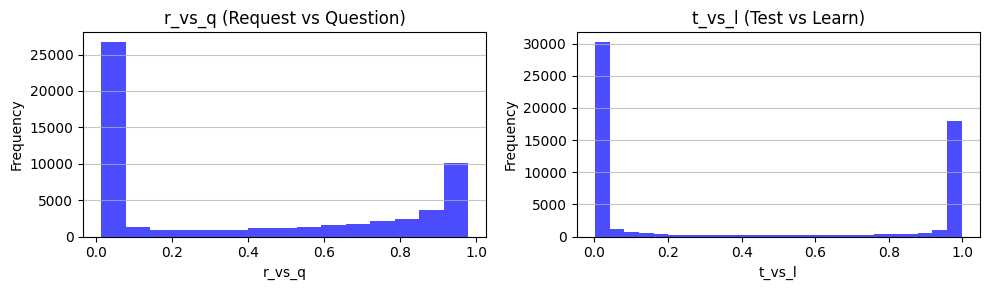

In [53]:
display(df_features[['id', 'prompt', 'label_rq', 'r_vs_q', 'label_tl', 't_vs_l']].sample(n=7))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.hist(df_features['r_vs_q'], bins=15, alpha=0.7, color='blue')
ax1.set_title('r_vs_q (Request vs Question)')
ax1.set_xlabel('r_vs_q')
ax1.set_ylabel('Frequency')
ax1.grid(axis='y', alpha=0.75)
ax2.hist(df_features['t_vs_l'], bins=25, alpha=0.7, color='blue')
ax2.set_title('t_vs_l (Test vs Learn)')
ax2.set_xlabel('t_vs_l')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

### Tie frequencies by prompt class

In [54]:
ties_summary = df_features.groupby(['label_rq', 'label_tl']).agg(
    total_records=('winner_tie', 'size'),
    sum_winner_tie=('winner_tie', 'sum')
).reset_index()
ties_summary['tie_ratio'] = ties_summary['sum_winner_tie'] / ties_summary['total_records']
if sampled: print(f"Showing statistics for {df_features.shape[0]} prompts")
display(ties_summary.sort_values(by='tie_ratio', ascending=False).style.hide(axis='index'))

### 2-D histogram of tie frequency per prompt class

In [55]:
def rqtl_hist2d(df, feature_a, feature_b, title='', gridsize=30):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(8, 6))

    # We map each item to a value before calculating densities in the 2D histogram:
    # 0: A or B wins, 1: Draw
    df.loc[:, 'tie'] = df['class_label'].map({0: 0, 1: 0, 2: 1})
    colors = plt.colormaps.get_cmap('Purples')

    sum_hist, xedges, yedges = np.histogram2d(df[feature_b], df[feature_a], bins=gridsize, weights=df['tie'])
    count_hist, _, _ = np.histogram2d(df[feature_b], df[feature_a], bins=gridsize)

    tie_frequency = np.divide(sum_hist, count_hist, out=np.zeros_like(sum_hist), where=count_hist != 0)

    # Plot the 2D histogram using the calculated tie percentage
    hb = ax.pcolormesh(xedges, yedges, tie_frequency.T, cmap=colors)

    ax.set_xlabel(feature_b)
    ax.set_ylabel(feature_a)
    ax.set_title(f'{title} - features {feature_a} & {feature_b}')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Prompt classes:
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_mid_right = xlim[1] - (xlim[1] - xlim[0]) / 4
    x_mid_left = xlim[0] + (xlim[1] - xlim[0]) / 4
    y_mid_upper = ylim[1] - (ylim[1] - ylim[0]) / 4
    y_mid_lower = ylim[0] + (ylim[1] - ylim[0]) / 4
    text_args = {'fontsize': 12, 'ha': 'center', 'va': 'center', 'color': 'black', 
                 'weight': 'bold', 'bbox': dict(facecolor='white', edgecolor='none')}
    ax.text(x_mid_right, y_mid_upper, 'RT - "Trick request"', **text_args) 
    ax.text(x_mid_left, y_mid_upper, 'RL - Request', **text_args) 
    ax.text(x_mid_right, y_mid_lower, 'QT - "Trick question"', **text_args) 
    ax.text(x_mid_left, y_mid_lower, 'QL - Question', **text_args)

    fig.colorbar(hb, ax=ax, label='Tie frequency')
    plt.tight_layout()
    plt.show()

Ties are notably more frequent when the user is "playing" rather than asking a direct question or making a direct request.
Ties are also more frequent when the classification between "question" and "request" is more ambiguous.


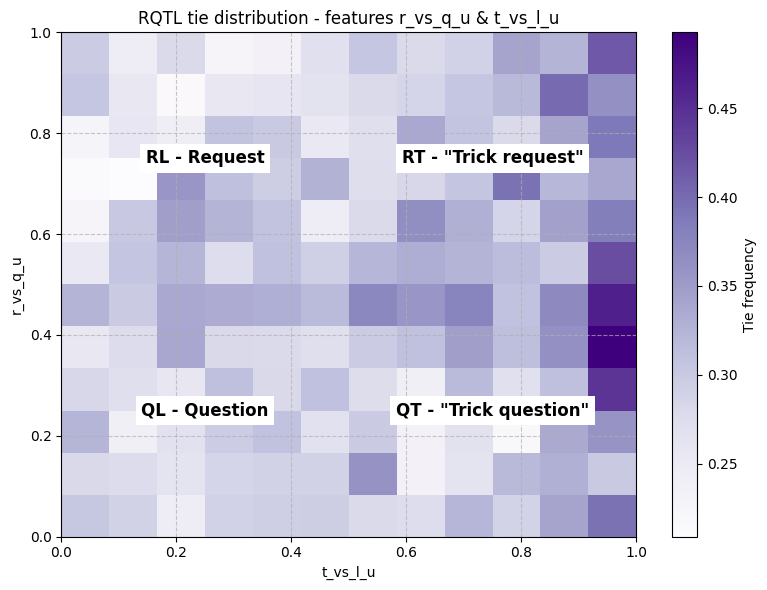

In [56]:
scaler = QuantileTransformer(output_distribution='uniform')
df_features['r_vs_q_u'] = scaler.fit_transform(df_features[['r_vs_q']])
df_features['t_vs_l_u'] = scaler.fit_transform(df_features[['t_vs_l']])
if not sampled:
    print('Ties are notably more frequent when the user is "playing" rather than asking a direct question or making a direct request.')
    print('Ties are also more frequent when the classification between "question" and "request" is more ambiguous.')
rqtl_hist2d(df_features, 'r_vs_q_u', 't_vs_l_u', title='RQTL tie distribution', gridsize = 12)

# 5. TF-IDF features (💡 Novelty Score)

We calculate TF-IDF (https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for prompt, response A, and response B, for every training/test item, where the corpus is the complete item (NOT THE DATA SET, THE INDIVIDUAL TRAINING/TEST ITEM)

### Function definition, examples and theory

In [57]:
def tf_idf_summary(corpus,verbose=True):
    start_time = time.time()
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = set(vectorizer.get_feature_names_out())
    if verbose:
        # unique_words = set(word for phrase in corpus for word in phrase.split()) # Doesn't work exactly like this in TfidfVectorizer
        print(feature_names)
        df_tfidf = pd.DataFrame(X.toarray(), columns=sorted(feature_names))
        # Index labels for our particular use case:
        index_labels = ['prompt', 'r_a', 'r_b'] + [f'row_{i}' for i in range(3, len(corpus))]
        df_tfidf.index = index_labels[:len(corpus)]
    else:
        df_tfidf = pd.DataFrame(X.toarray())
    df_tfidf['tfidf_avg'] = df_tfidf.replace(0, pd.NA).mean(axis=1) # Average TFIDF score of words present in the text
    if verbose: print(f"Runtime: {time.time() - start_time:.8f} s")
    else:
        pass # debugging traces below
        # clear_output(wait=True)
        # print(f"Last runtime: {time.time() - start_time:.8f} s")
    return df_tfidf

print('Prompt with high TFIDF:')
corpus = ["Give me five", "Five", "As a large language model I lack the ability to give five"]
print(corpus)
df_tfidf = tf_idf_summary(corpus, verbose=True)
display(df_tfidf)
print('Prompt with low TFIDF:')
corpus = ["Hello, I want you to assist me with a task", "Sure, go ahead", "I am here to assist you, which task can I help you with?"]
print(corpus)
df_tfidf = tf_idf_summary(corpus, verbose=True)
display(df_tfidf)
print('Responses with low TFIDF (novel):')
corpus = ["Tell me a naughty joke", "Why don't scientists trust atoms? Because they make up everything!", "Why did the tomato turn red? Because it saw the salad dressing! (This joke is considered inappropriate and offensive, so please use it with caution.)"]
print(corpus)
df_tfidf = tf_idf_summary(corpus, verbose=True)
display(df_tfidf)

Prompt with high TFIDF:
['Give me five', 'Five', 'As a large language model I lack the ability to give five']
{'five', 'large', 'language', 'model', 'me', 'lack', 'as', 'the', 'give', 'ability', 'to'}
Runtime: 0.01180458 s


ability        as      five      give      lack  language     large  \
prompt  0.000000  0.000000  0.425441  0.547832  0.000000  0.000000  0.000000   
r_a     0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
r_b     0.334689  0.334689  0.197673  0.254540  0.334689  0.334689  0.334689   

              me     model       the        to tfidf_avg  
prompt  0.720333  0.000000  0.000000  0.000000  0.564535  
r_a     0.000000  0.000000  0.000000  0.000000       1.0  
r_b     0.000000  0.334689  0.334689  0.334689  0.312973

Prompt with low TFIDF:
['Hello, I want you to assist me with a task', 'Sure, go ahead', 'I am here to assist you, which task can I help you with?']
{'ahead', 'assist', 'here', 'go', 'with', 'am', 'help', 'you', 'can', 'me', 'want', 'which', 'task', 'sure', 'hello', 'to'}
Runtime: 0.00462174 s


ahead        am    assist       can       go     hello      help  \
prompt  0.00000  0.000000  0.313316  0.000000  0.00000  0.411973  0.000000   
r_a     0.57735  0.000000  0.000000  0.000000  0.57735  0.000000  0.000000   
r_b     0.00000  0.322292  0.245112  0.322292  0.00000  0.000000  0.322292   

            here        me     sure      task        to      want     which  \
prompt  0.000000  0.411973  0.00000  0.313316  0.313316  0.411973  0.000000   
r_a     0.000000  0.000000  0.57735  0.000000  0.000000  0.000000  0.000000   
r_b     0.322292  0.000000  0.00000  0.245112  0.245112  0.000000  0.322292   

            with       you tfidf_avg  
prompt  0.313316  0.313316  0.350312  
r_a     0.000000  0.000000   0.57735  
r_b     0.245112  0.490223  0.308213

Responses with low TFIDF (novel):
['Tell me a naughty joke', "Why don't scientists trust atoms? Because they make up everything!", 'Why did the tomato turn red? Because it saw the salad dressing! (This joke is considered inappropriate and offensive, so please use it with caution.)']
{'atoms', 'they', 'considered', 'tell', 'up', 'this', 'the', 'turn', 'dressing', 'with', 'saw', 'joke', 'because', 'me', 'is', 'make', 'tomato', 'use', 'caution', 'so', 'naughty', 'and', 'it', 'salad', 'trust', 'don', 'everything', 'did', 'please', 'red', 'scientists', 'inappropriate', 'offensive', 'why'}
Runtime: 0.00475812 s


and     atoms   because   caution  considered       did  \
prompt  0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
r_a     0.000000  0.330467  0.251329  0.000000    0.000000  0.000000   
r_b     0.189882  0.000000  0.144410  0.189882    0.189882  0.189882   

             don  dressing  everything  inappropriate  ...      they  \
prompt  0.000000  0.000000    0.000000       0.000000  ...  0.000000   
r_a     0.330467  0.000000    0.330467       0.000000  ...  0.330467   
r_b     0.000000  0.189882    0.000000       0.189882  ...  0.000000   

            this    tomato     trust      turn        up       use       why  \
prompt  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r_a     0.000000  0.000000  0.330467  0.000000  0.330467  0.000000  0.251329   
r_b     0.189882  0.189882  0.000000  0.189882  0.000000  0.189882  0.144410   

            with  tfidf_avg  
prompt  0.000000   0.496986  
r_a     0.000000   0.314639  
r_b     0.189882   0.200463  

[3 rows x 35 columns]

Now let's check a simplistic example from the data set. This is obviously not conclusive, but illustrates how the tfidf_avg metric for prompt, response A, and response B will supply significant information to our models:

In [58]:
# example = df.loc[df['id'] == 2447300783, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
# print(example)
tfidf_test_corpus = df.loc[df['id'] == 2447300783, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
print("[prompt, ra, rb] -> ",tfidf_test_corpus)
df_tfidf_test = tf_idf_summary(tfidf_test_corpus, verbose=True)
display(df_tfidf_test)

[prompt, ra, rb] ->  ['test me', 'Hello! How can I help you?', 'yes']
{'yes', 'help', 'can', 'me', 'test', 'how', 'hello', 'you'}
Runtime: 0.00363541 s


can     hello      help       how        me      test  yes  \
prompt  0.000000  0.000000  0.000000  0.000000  0.707107  0.707107  0.0   
r_a     0.447214  0.447214  0.447214  0.447214  0.000000  0.000000  0.0   
r_b     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.0   

             you tfidf_avg  
prompt  0.000000  0.707107  
r_a     0.447214  0.447214  
r_b     0.000000       1.0

In [59]:
tfidf_test_corpus = df.loc[df['id'] == 1110836523, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
print("[prompt, ra, rb] -> ",tfidf_test_corpus)
df_tfidf_test = tf_idf_summary(tfidf_test_corpus, verbose=True)
display(df_tfidf_test)

[prompt, ra, rb] ->  ['What should I do in life to be happier?', "There are many things you can do to increase your happiness in life. Here are some suggestions:\n\n1. Practice gratitude: Take time each day to reflect on the things you are grateful for. This can help shift your focus away from negative thoughts and cultivate a more positive outlook.\n2. Cultivate strong relationships: Surround yourself with people who support and uplift you. Nurturing strong relationships can bring joy and fulfillment to your life.\n3. Take care of your physical health: Regular exercise, healthy eating, and sufficient sleep can all contribute to a sense of well-being and happiness.\n4. Engage in activities you enjoy: Make time for hobbies, passions, and creative pursuits that bring you joy and fulfillment.\n5. Practice mindfulness: Focus on the present moment and let go of worries about the past or future. Mindfulness practices such as meditation and deep breathing can help you cultivate a sense of cal

10     about    accept  acceptance  achievable    action  \
prompt  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000   
r_a     0.032746  0.024905  0.000000    0.024905    0.032746  0.032746   
r_b     0.000000  0.033170  0.087229    0.033170    0.000000  0.000000   

        activities      acts     after      aims  ...      will      with  \
prompt    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
r_a       0.024905  0.049809  0.000000  0.000000  ...  0.000000  0.049809   
r_b       0.033170  0.033170  0.043615  0.043615  ...  0.043615  0.066340   

            work     works   worries  worrying       you      your  yourself  \
prompt  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r_a     0.098239  0.000000  0.032746  0.000000  0.224141  0.174332  0.074714   
r_b     0.000000  0.043615  0.000000  0.043615  0.331700  0.199020  0.132680   

        tfidf_avg  
prompt    0.34645  
r_a      0.051156  
r_b      0.055969  

[3 rows x 253 columns]

### Novelty scores exploration

Check notebook lmsys-cba-reddgr-scbn-rqtl-kaggle.ipynb for full Novelty score calculation process. The dataset loaded in this notebook already contains the scores calculated on the train dataset.

In [67]:
# Quick gathering of examples to analyze (we can try to spot cases with high disparity in N scores)
pd.options.display.float_format = '{:.3f}'.format
df_sample = df.sample(n=5).sort_values(by='N_score_a', ascending = False)
display(df_sample[['id','tfidf_prompt','tfidf_ra','tfidf_rb', 'N_score_a', 'N_score_b','class_label']])
pd.reset_option('display.float_format')

id  tfidf_prompt  tfidf_ra  tfidf_rb  N_score_a  N_score_b  \
52430  3919434968         0.293     0.101     0.142      0.603      0.578   
12821   950723867         0.324     0.214     0.098      0.560      0.617   
56576  4228017915         0.176     0.104     0.096      0.541      0.541   
13036   966485855         0.070     0.058     0.057      0.509      0.507   
222      17452762         0.128     0.164     0.079      0.485      0.526   

       class_label  
52430            2  
12821            1  
56576            2  
13036            0  
222              1

### Scatter plot analysis for 💡 Novelty Score

Scatter plot analysis suggests a correlation between what we defined as "Novelty Score" and human response preference (there are more "B wins" outcomes on the lower-right part of the plot, where N score of response B is higher than N score of response A) 

In [62]:
def plot_scatter(df, feature_a, feature_b, range_min=None, range_max=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    colors = {0: 'lime', 1: 'darkgreen', 2: 'grey'}
    label_to_name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'tie'}

    # First subplot (all data)
    for class_label in [0, 1, 2]:
        mask = df['class_label'] == class_label
        ax1.scatter(df.loc[mask, feature_b],
                    df.loc[mask, feature_a],
                    c=colors[class_label],
                    label=label_to_name[class_label],
                    alpha=0.6, s=1)

    ax1.set_xlabel(feature_b)
    ax1.set_ylabel(feature_a)
    ax1.set_title(f'{feature_b} vs {feature_a} (all data)')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Set axis limits for first subplot if range is specified
    if range_min is not None and range_max is not None:
        ax1.set_xlim(range_min, range_max)
        ax1.set_ylim(range_min, range_max)

    # Second subplot (excluding ties)
    for class_label in [0, 1]:
        mask = df['class_label'] == class_label
        ax2.scatter(df.loc[mask, feature_b],
                    df.loc[mask, feature_a],
                    c=colors[class_label],
                    label=label_to_name[class_label],
                    alpha=0.4, s=1)

    ax2.set_xlabel(feature_b)
    ax2.set_ylabel(feature_a)
    ax2.set_title(f'{feature_b} vs {feature_a} (excluding ties)')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.3)

    # Set axis limits for second subplot if range is specified
    if range_min is not None and range_max is not None:
        ax2.set_xlim(range_min, range_max)
        ax2.set_ylim(range_min, range_max)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

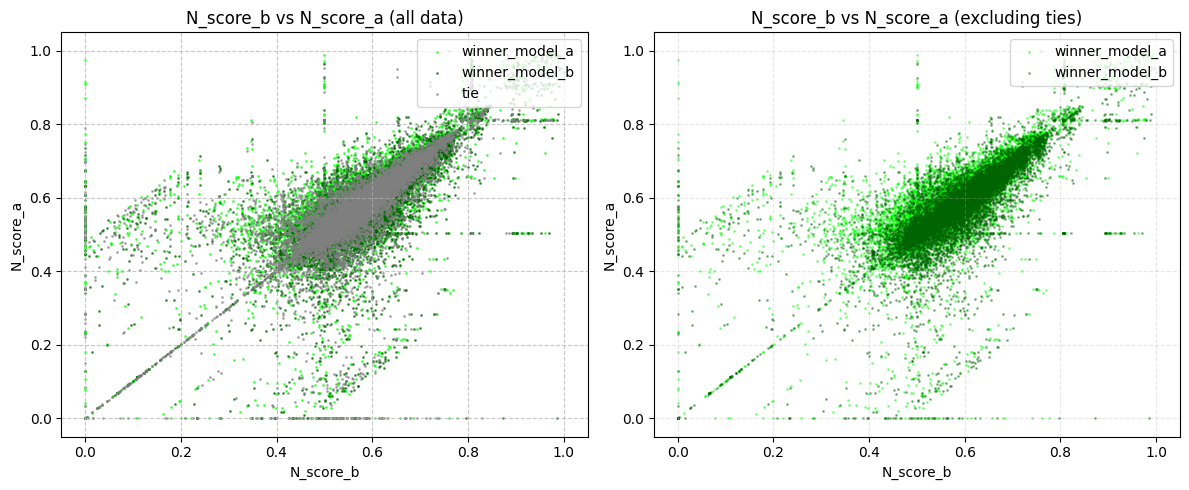

In [63]:
sampling = 1
df_sample = df.sample(n=int(sampling*len(df)))
plot_scatter(df_sample, 'N_score_a', 'N_score_b')

### Histograms for 💡 Novelty Score

We can better visualize this correlation by calculating all the differences between the score of the "winner" response and the score of the "loser" response. It is clearly noticeable that winner responses tend to score higher in this metric. Furthermore, we can observe ties have a bias towards cases where the response A scores higher. 

In [68]:
def hist_feature_diff(df, feature_a, feature_b, title='Feature comparison', range_min=-0.1, range_max=0.1, nbins=100, exclude_zeroes=False):
    df['winner_vs_loser'] = df.apply(
        lambda row: row[feature_a] - row[feature_b] if row['class_label'] == 0  # Feature A vs feature B when Model A wins
        else row[feature_b] - row[feature_a], axis=1) # Feature B vs feature A otherwise

    # Non-ties
    df_non_tie = df[df['class_label'] != 2]
    mean_non_tie = df_non_tie['winner_vs_loser'].mean()
    median_non_tie = df_non_tie['winner_vs_loser'].median()
    print(f"Average {title} (winner vs loser): {mean_non_tie:.4f}")
    # Histogram:
    plt.figure(figsize=(10, 5))
    plt.hist(df_non_tie['winner_vs_loser'].dropna(), bins=nbins, color='blue', range=(range_min, range_max))
    plt.axvline(mean_non_tie, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_non_tie, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=2)
    plt.title(f"{title} - winner vs loser (Non-ties)")
    plt.xlabel("winner_vs_loser")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Response A wins:
    df_class_0 = df_non_tie[df_non_tie['class_label'] == 0]
    mean_class_0 = df_class_0['winner_vs_loser'].mean()
    median_class_0 = df_class_0['winner_vs_loser'].median()
    print(f"Average {title} (Model A wins): {mean_class_0:.4f}")
    plt.figure(figsize=(10, 5))
    plt.hist(df_class_0['winner_vs_loser'].dropna(), bins=nbins, color='orange', range=(range_min, range_max))
    plt.axvline(mean_class_0, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_class_0, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=2)
    plt.title(f"{title} - Model A wins (Non-ties)")
    plt.xlabel("winner_vs_loser")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Response B wins:
    df_class_1 = df_non_tie[df_non_tie['class_label'] == 1]
    mean_class_1 = df_class_1['winner_vs_loser'].mean()
    median_class_1 = df_class_1['winner_vs_loser'].median()
    print(f"Average {title} (Model B wins): {mean_class_1:.4f}")
    plt.figure(figsize=(10, 5))
    plt.hist(df_class_1['winner_vs_loser'].dropna(), bins=nbins, color='purple', range=(range_min, range_max))
    plt.axvline(mean_class_1, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_class_1, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=2)
    plt.title(f"{title} - Model B wins (Non-ties)")
    plt.xlabel("winner_vs_loser")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Filter for ties:
    df_tie = df[df['class_label'] == 2]
    mean_tie = df_tie['winner_vs_loser'].mean()
    median_tie = df_tie['winner_vs_loser'].median()
    print(f"Average {title} (ties): {mean_tie:.4f}")

    # Histogram for ties:
    plt.figure(figsize=(10, 5))
    plt.hist(df_tie['winner_vs_loser'].dropna(), bins=nbins, color='green', range=(range_min, range_max))
    plt.axvline(mean_tie, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_tie, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=2)
    plt.title(f"{title} - ties")
    plt.xlabel(f"{feature_b} vs {feature_a}")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Average Relative Novelty Score (winner vs loser): 0.0081


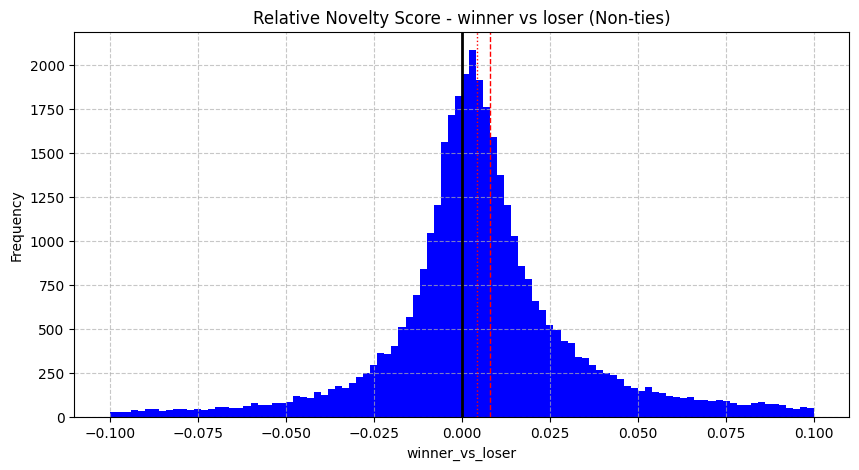

Average Relative Novelty Score (Model A wins): 0.0111


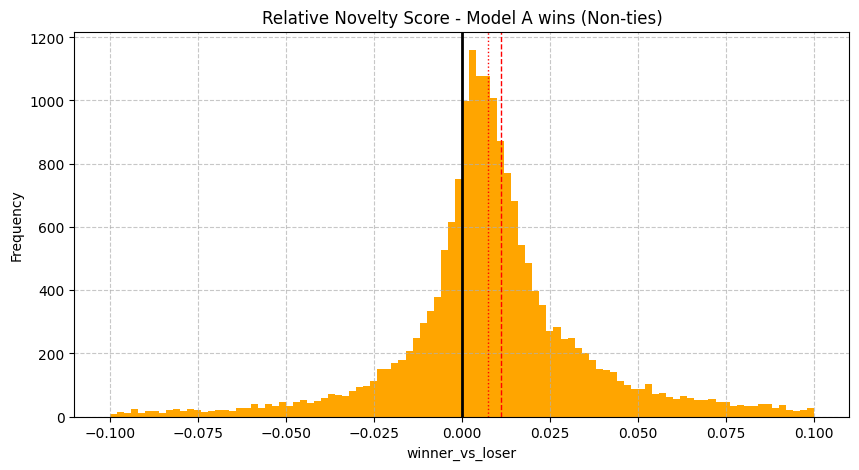

Average Relative Novelty Score (Model B wins): 0.0051


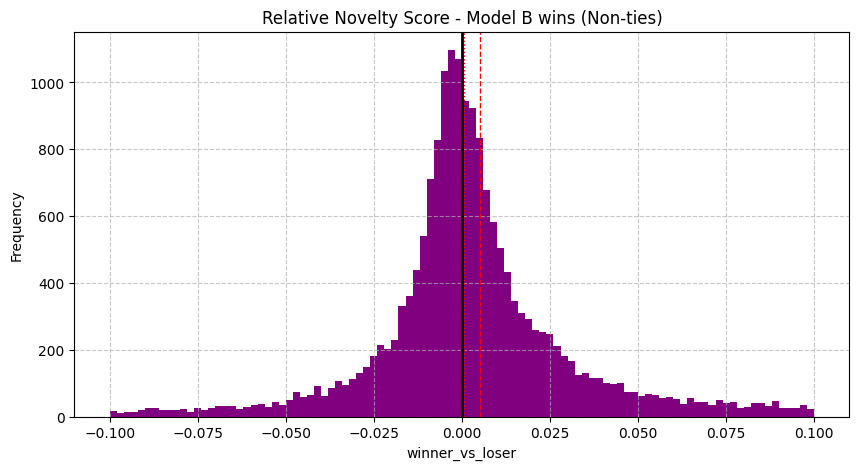

Average Relative Novelty Score (ties): -0.0036


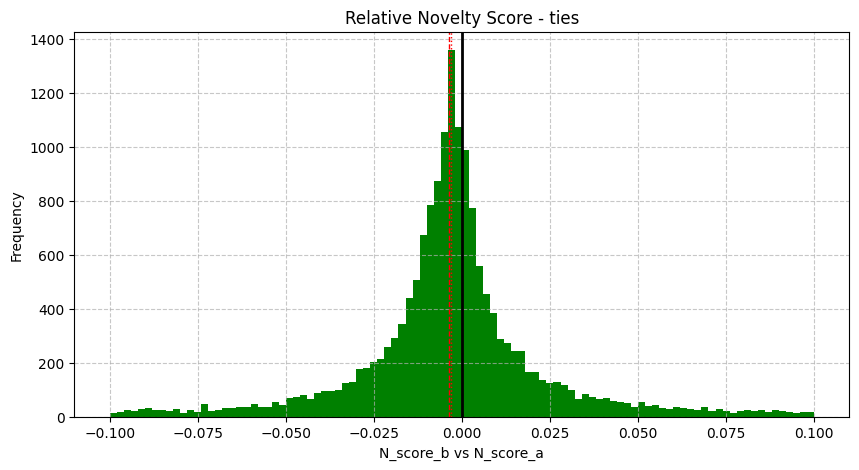

In [69]:
hist_feature_diff(df, 'N_score_a', 'N_score_b', "Relative Novelty Score", range_min=-0.1, range_max=0.1, nbins=100)

### Hexbin plots for 💡 Novelty Score

Scatter plots with such a large amount of data points and high dispersion are not very useful for understanding correlations. We will map the dots to a hexbin chart and define a metric where 1 means B is the chosen response, 0 means A is chosen, and 0.5 means a tie. By averaging all the values that fall within each hexagon in the hexbin, we can observe how the metrics we defined correlate with user preference.

In [70]:
def plot_hexbin(df, feature_a, feature_b, title='', gridsize=30, range_min=None, range_max=None):
    df = df.copy()

    fig, ax = plt.subplots(figsize=(8, 6))

    # We map each item to a value before calculating densities in the hexbin:
    # 0: A wins, 1: B wins, 0.5: Draw
    df.loc[:, 'response_b_win'] = df['class_label'].map({0: 0, 1: 1, 2: 0.5})
    # colors = plt.cm.get_cmap('coolwarm')
    colors = plt.colormaps.get_cmap('coolwarm')

    # We determine the range automatically if not provided
    if range_min is None:
        range_min = min(df[feature_a].min(), df[feature_b].min())
    if range_max is None:
        range_max = max(df[feature_a].max(), df[feature_b].max())

    # Hexbin plot for the data
    hb = ax.hexbin(df[feature_b], 
                   df[feature_a], 
                   C=df['response_b_win'],
                   gridsize=gridsize, 
                   cmap=colors, 
                   reduce_C_function=np.mean, 
                   mincnt=1,
                   extent=(range_min, range_max, range_min, range_max))

    ax.set_xlabel(feature_b)
    ax.set_ylabel(feature_a)
    ax.set_title(f'{feature_b} vs {feature_a} - {title}')
    ax.grid(True, linestyle='--', alpha=0.7)
    fig.colorbar(hb, ax=ax, label='Response B Win Density')
    plt.tight_layout()
    plt.show()

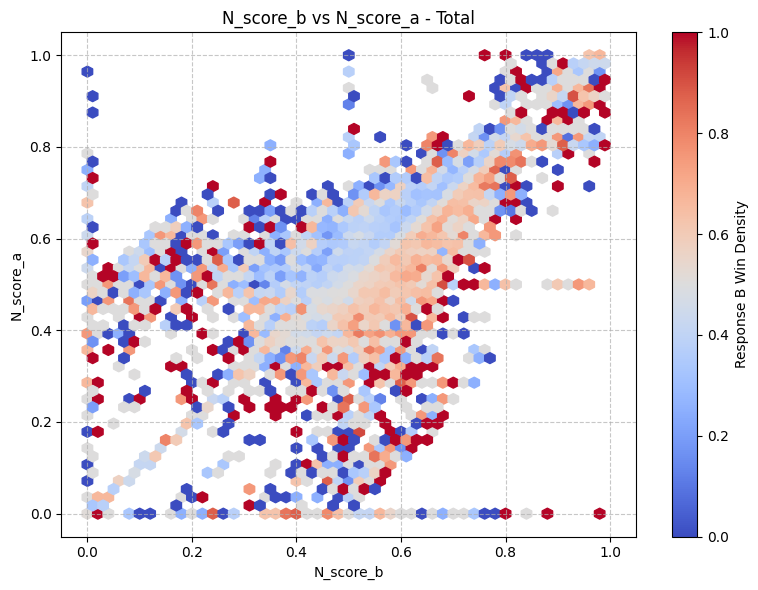

In [71]:
plot_hexbin(df, 'N_score_a', 'N_score_b', title='Total',gridsize=50)

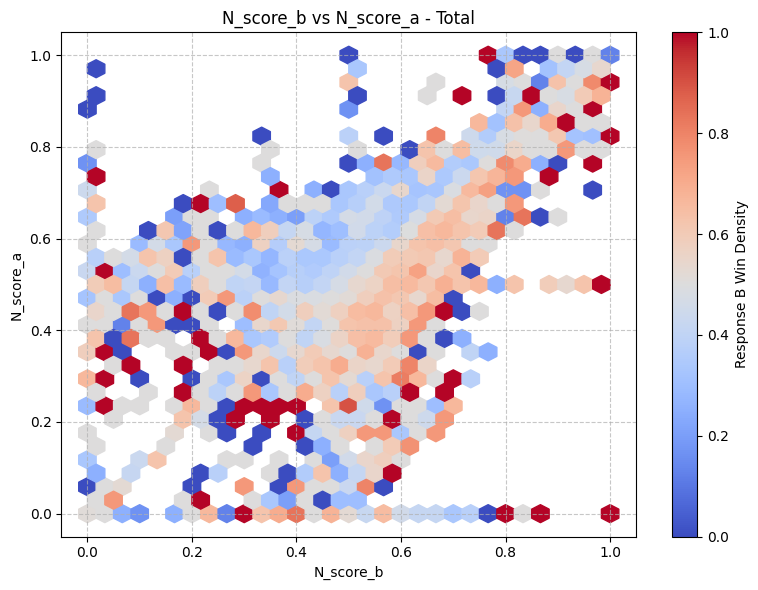

Regular questions (question-instruction). N scores have generally high predictive value:


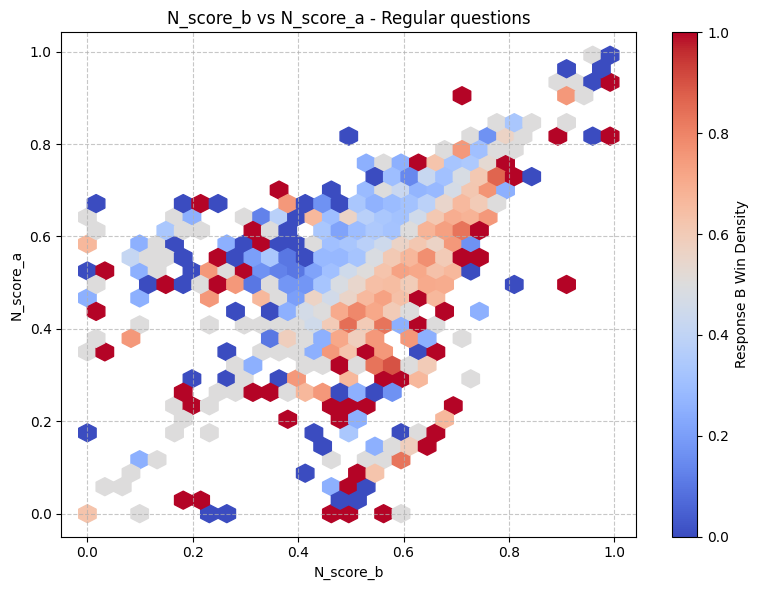

Trick questions (question-problem). N scores have low predictive value


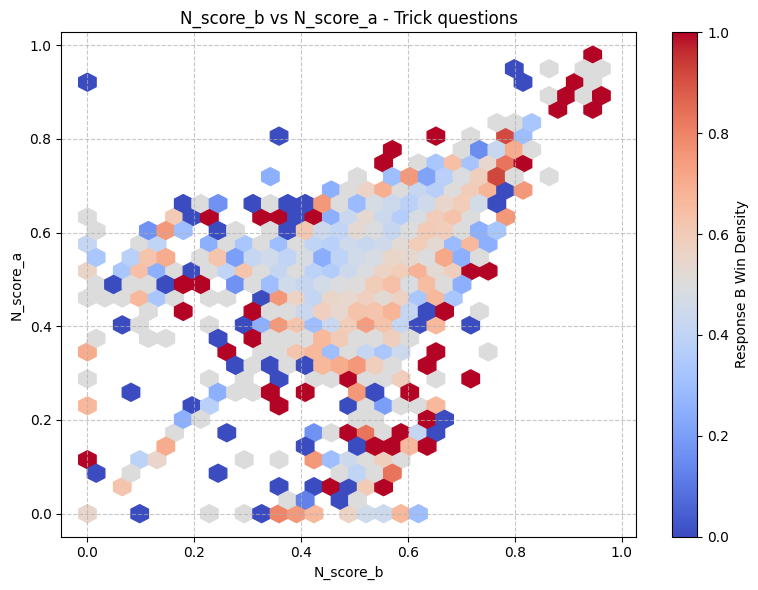

Regular requests (request-instruction). Medium and low N scores have more predictive value:


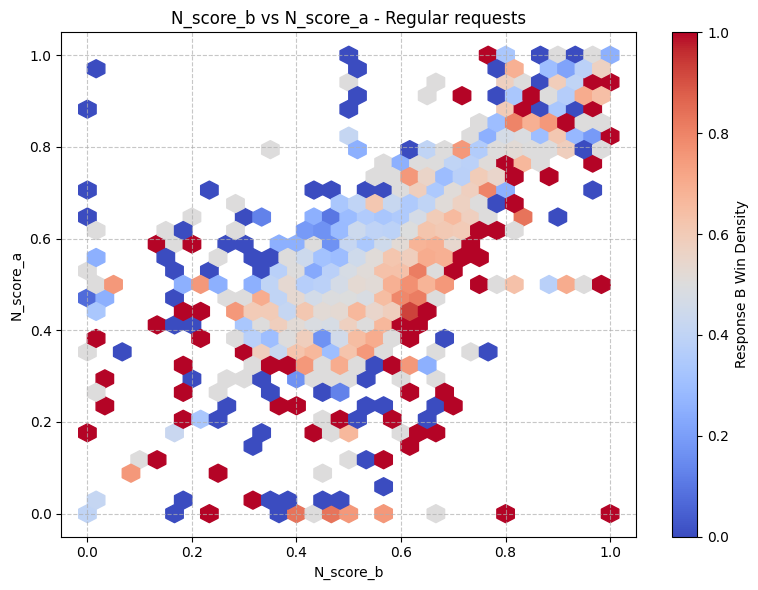

Problem-solving requests (request-problem). Medium and high N scores have more predictive value:


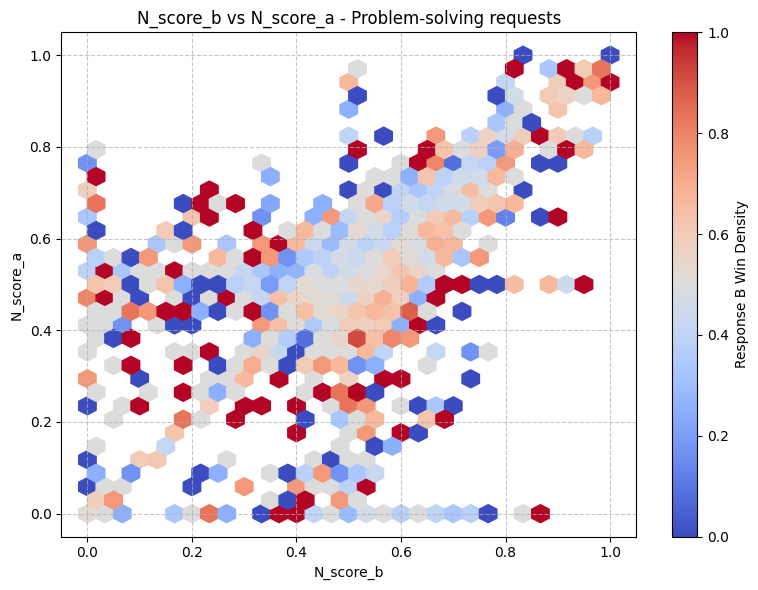

In [72]:
sampling = 1 # No need to sample with this chart, but I keep this just to reuse the variable names with the _sample suffix
resolution = 30
df_sample = df.sample(n=int(sampling*len(df)))
plot_hexbin(df_sample, 'N_score_a', 'N_score_b', title='Total', gridsize=resolution)

print('Regular questions (question-instruction). N scores have generally high predictive value:')
df_sample_qi = df_sample[(df_sample['label_rq'] == 'question') & (df_sample['label_tl'] == 'instruction')]
plot_hexbin(df_sample_qi, 'N_score_a', 'N_score_b', title='Regular questions', gridsize=resolution)

print('Trick questions (question-problem). N scores have low predictive value')
df_sample_qp = df_sample[(df_sample['label_rq'] == 'question') & (df_sample['label_tl'] == 'problem')]
plot_hexbin(df_sample_qp, 'N_score_a', 'N_score_b', title='Trick questions', gridsize=resolution)

print('Regular requests (request-instruction). Medium and low N scores have more predictive value:')
df_sample_ri = df_sample[(df_sample['label_rq'] == 'request') & (df_sample['label_tl'] == 'instruction')]
plot_hexbin(df_sample_ri, 'N_score_a', 'N_score_b', title='Regular requests', gridsize=resolution)

print('Problem-solving requests (request-problem). Medium and high N scores have more predictive value:')
df_sample_rp = df_sample[(df_sample['label_rq'] == 'request') & (df_sample['label_tl'] == 'problem')]
plot_hexbin(df_sample_rp, 'N_score_a', 'N_score_b', title='Problem-solving requests', gridsize=resolution)

# 6. SC features (🎯 Specificity Score, 🧩 Coherency Score)

TextBlob Example:

In [73]:
def get_sentiment(text):
  sentiment = TextBlob(text).sentiment
  polarity_score = sentiment.polarity  # Between -1 (negative) and 1 (positive)
  subjectivity_score = sentiment.subjectivity  # Between 0 (objective) and 1 (subjective)
  return polarity_score, subjectivity_score


text = "As a large language model I'm proud of my ability to pass butter."
polarity_score, subjectivity_score = get_sentiment(text)

print(text)
print(f"Polarity: {polarity_score}")
print(f"Subjectivity: {subjectivity_score}")
text2 = "As a small language model I lack the ability to pass butter."
polarity_score2, subjectivity_score2 = get_sentiment(text2)
print(text2)
print(f"Polarity: {polarity_score2}")
print(f"Subjectivity: {subjectivity_score2}")
print("POLARITY: Between -1 (negative sentiment) and 1 (positive sentiment)")
print("SUBJECTIVITY: Between 0 (objective) and 1 (subjective)")

As a large language model I'm proud of my ability to pass butter.
Polarity: 0.5071428571428571
Subjectivity: 0.7142857142857143
As a small language model I lack the ability to pass butter.
Polarity: -0.25
Subjectivity: 0.4
POLARITY: Between -1 (negative sentiment) and 1 (positive sentiment)
SUBJECTIVITY: Between 0 (objective) and 1 (subjective)


Example from dataset

In [74]:
sa_test_prompt, sa_test_ra, sa_test_rb = df.loc[df['id'] == 2747109329, ['prompt', 'response_a', 'response_b']].values.flatten()
polarity_score_p, subjectivity_score_p = get_sentiment(sa_test_prompt)
polarity_score_ra, subjectivity_score_ra = get_sentiment(sa_test_ra)
polarity_score_rb, subjectivity_score_rb = get_sentiment(sa_test_rb)

print(sa_test_prompt)
print(f"Polarity: {polarity_score_p}")
print(f"Subjectivity: {subjectivity_score_p}")
print(sa_test_ra)
print(f"Polarity: {polarity_score_ra}")
print(f"Subjectivity: {subjectivity_score_ra}")
print(sa_test_rb)
print(f"Polarity: {polarity_score_rb}")
print(f"Subjectivity: {subjectivity_score_rb}")

What will the weather be like tomorrow?
Polarity: 0.0
Subjectivity: 0.0
I'm sorry, I cannot provide you with the weather forecast since I am an AI language model and do not have real-time access to weather data. However, you can check the weather forecast on your local news channel or on a weather website.
Polarity: -0.25
Subjectivity: 0.5
The weather is expected to be sunny tomorrow.
Polarity: -0.1
Subjectivity: 0.4


### Calculate Specificity and Coherency scores:

See notebook lmsys-cba-reddgr-scbn-rqtl-kaggle.ipynb. The dataset loaded in this notebook contains all calculated metrics.

### Histograms for 🎯 Specificity Score

At the moment of writing this comment, the correlation of Specificity score with human preference is confirmed, but the model used for sentiment analysis fails to classify a large number of prompts and responses, leading to relative scores of 0 (as observed in the histograms). This simply means there's room for improvement in our model when we use a more advanced sentiment analysis model tailored for this dataset (WORK IN PROGRESS AS I DEVELOP THIS NOTEBOOK AND PUBLISH MY FINDINGS)

Average Relative Specificity Score (winner vs loser): 0.0082


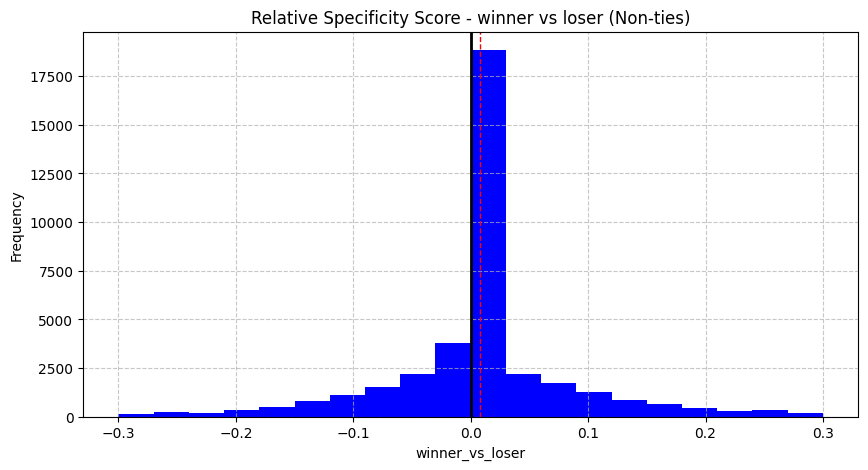

Average Relative Specificity Score (Model A wins): 0.0085


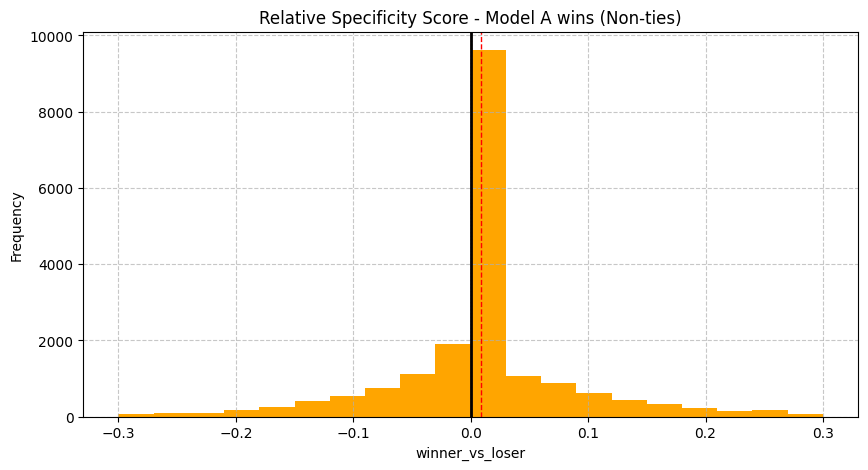

Average Relative Specificity Score (Model B wins): 0.0079


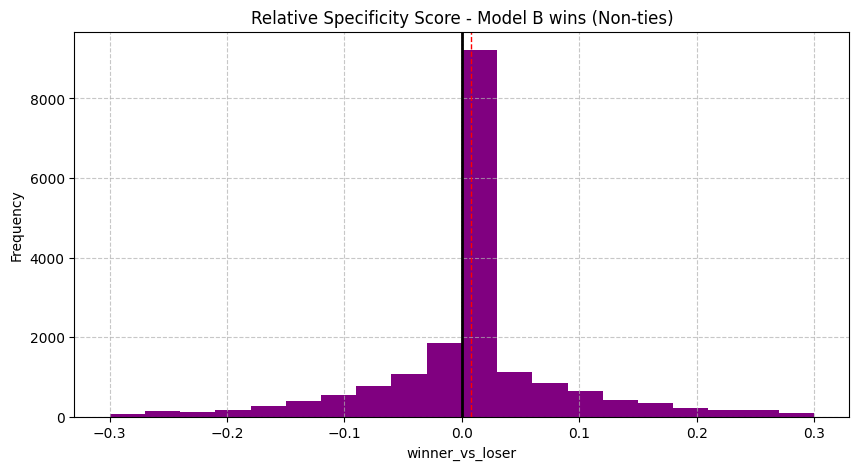

Average Relative Specificity Score (ties): 0.0002


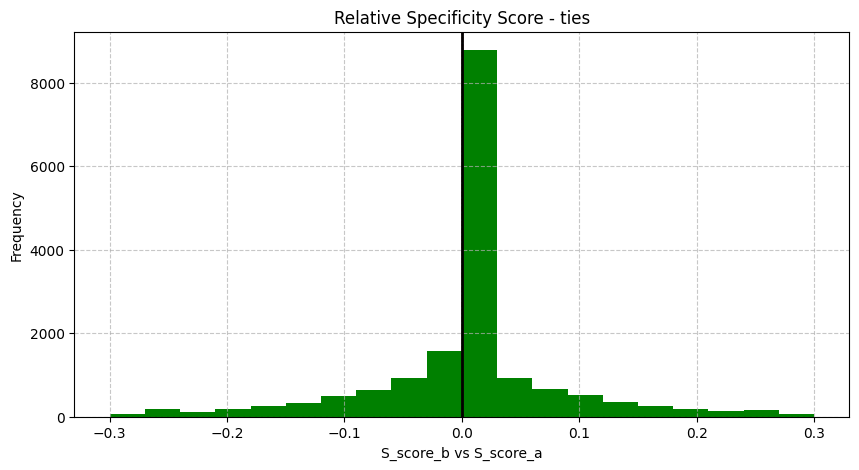

In [76]:
hist_feature_diff(df, 'S_score_a', 'S_score_b', "Relative Specificity Score", range_min=-0.3, range_max=0.3, nbins=20)

### Hexbin plots for 🎯 Specificity Score

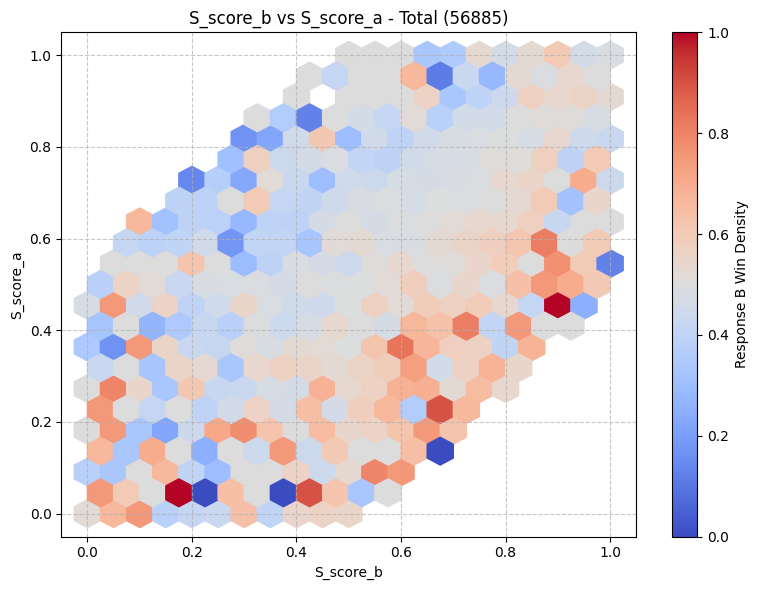

In [77]:
plot_hexbin(df, 'S_score_a', 'S_score_b', title=f'Total ({df.shape[0]})', gridsize=20)

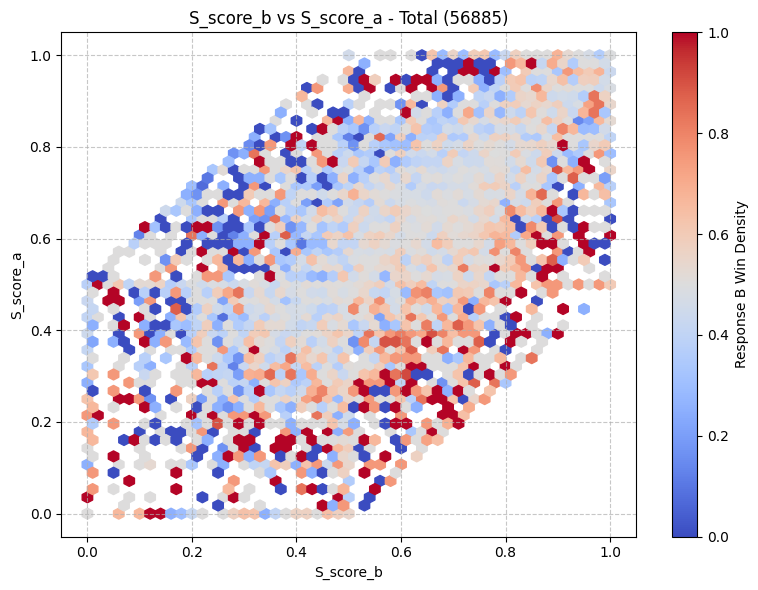

Regular questions (question-instruction). S scores are mildly correlated with user choice, specially in the extremes:


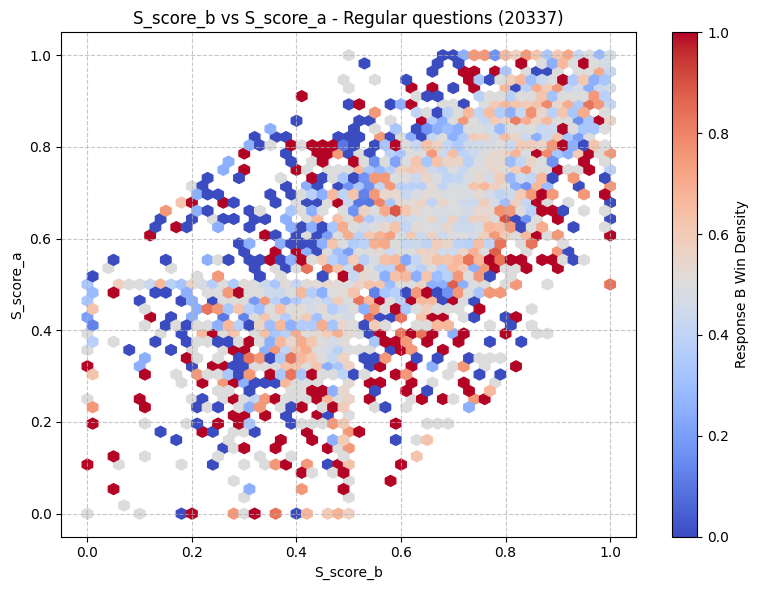

Trick questions (question-problem). S scores have higher predictive value in the mid-range


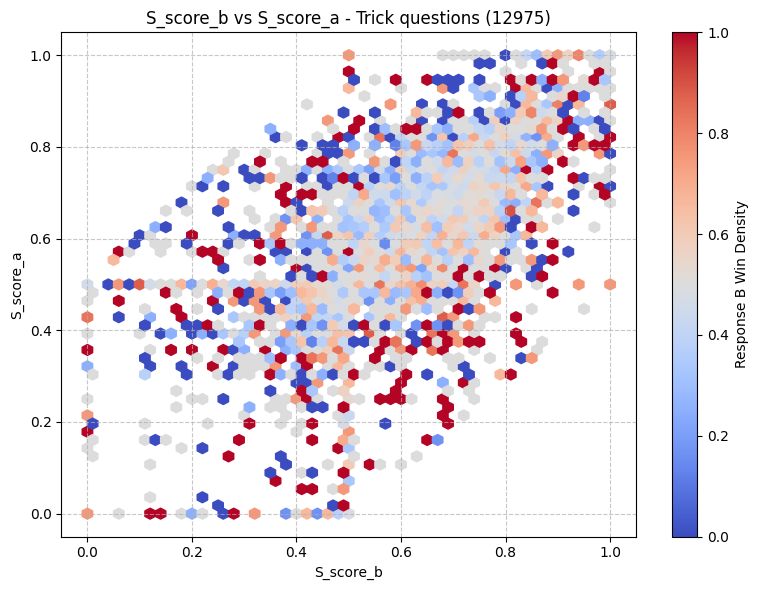

Regular requests (request-instruction). S scores have the lowest predictive value:


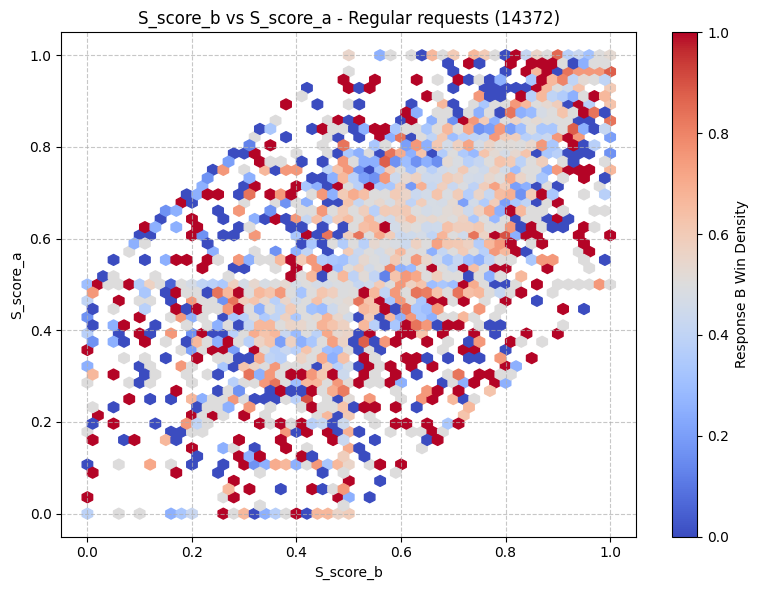

Problem-solving requests (request-problem). S scores have more predictive value than C scores, specially near the extremes (see C-score plots):


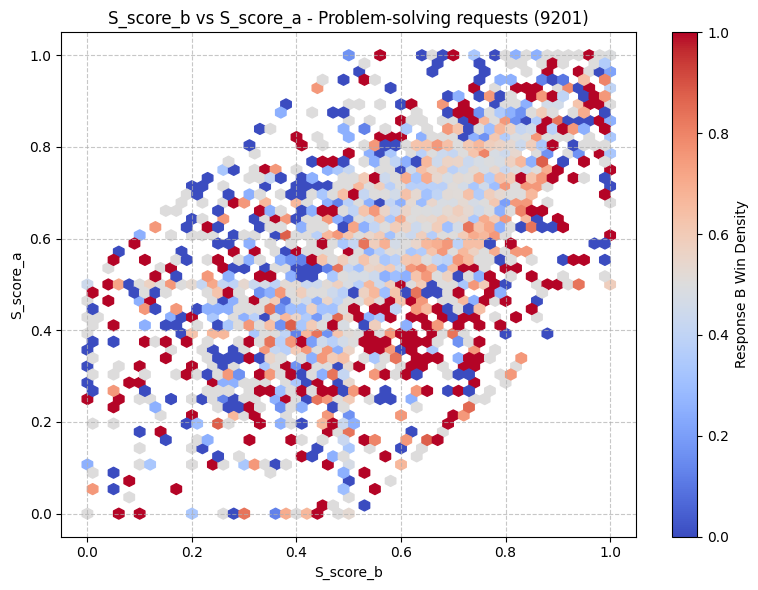

In [78]:
resolution = 50
plot_hexbin(df, 'S_score_a', 'S_score_b', title=f'Total ({df.shape[0]})', gridsize=resolution)

print('Regular questions (question-instruction). S scores are mildly correlated with user choice, specially in the extremes:')
df_qi = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_qi, 'S_score_a', 'S_score_b', title=f'Regular questions ({df_qi.shape[0]})', gridsize=resolution)

print('Trick questions (question-problem). S scores have higher predictive value in the mid-range')
df_qp = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'problem')]
plot_hexbin(df_qp, 'S_score_a', 'S_score_b', title=f'Trick questions ({df_qp.shape[0]})', gridsize=resolution)

print('Regular requests (request-instruction). S scores have the lowest predictive value:')
df_ri = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_ri, 'S_score_a', 'S_score_b', title=f'Regular requests ({df_ri.shape[0]})', gridsize=resolution)

print('Problem-solving requests (request-problem). S scores have more predictive value than C scores, specially near the extremes (see C-score plots):')
df_rp = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'problem')]
plot_hexbin(df_rp, 'S_score_a', 'S_score_b', title=f'Problem-solving requests ({df_rp.shape[0]})', gridsize=resolution)

### Histograms for 🧩 Coherency Score

Average Relative Coherency Score (winner vs loser): 0.0033


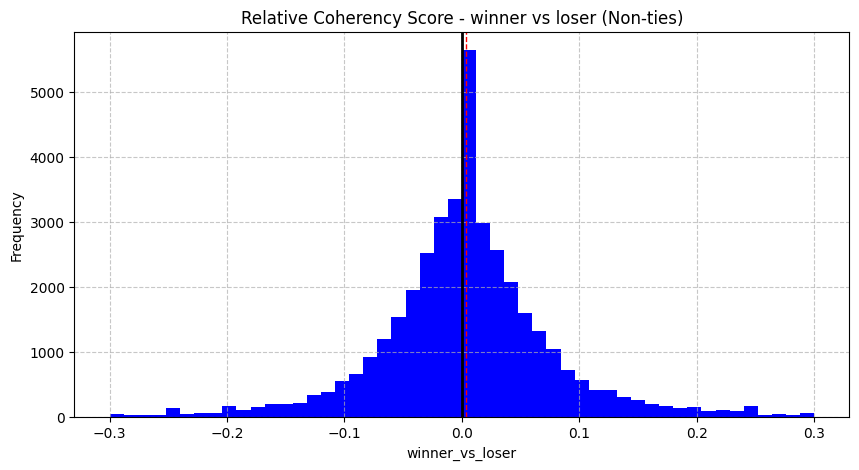

Average Relative Coherency Score (Model A wins): 0.0034


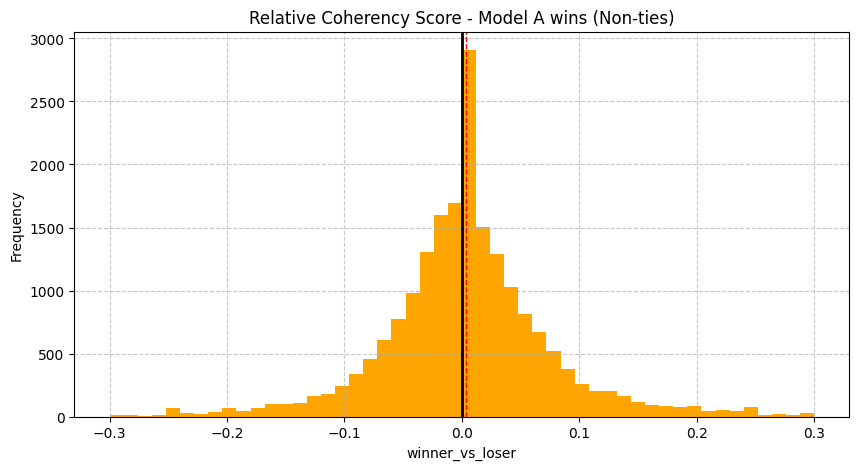

Average Relative Coherency Score (Model B wins): 0.0032


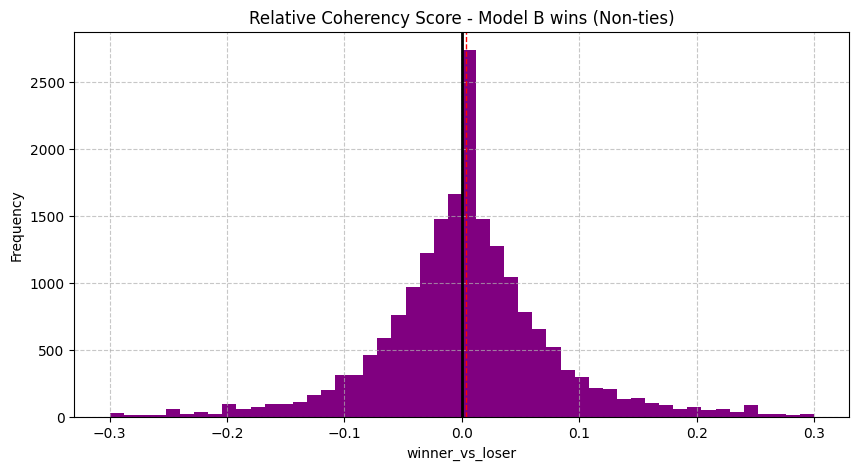

Average Relative Coherency Score (ties): -0.0002


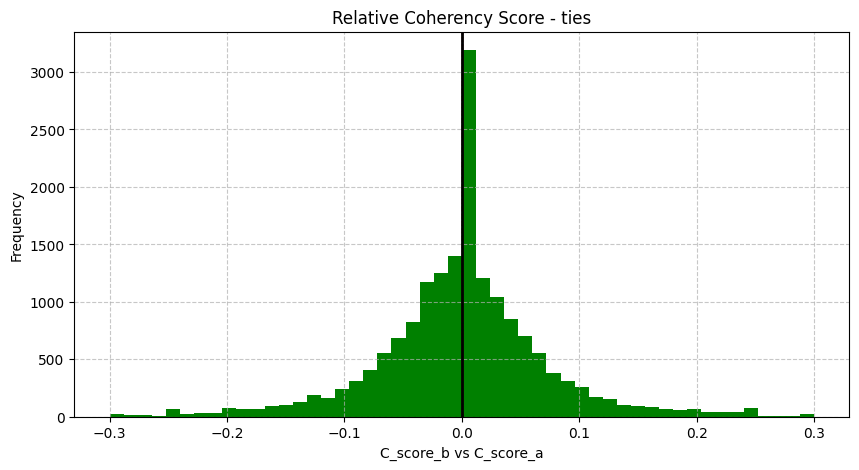

In [79]:
hist_feature_diff(df, 'C_score_a', 'C_score_b', "Relative Coherency Score", range_min=-0.3, range_max=0.3, nbins=50)

### Hexbin plots for 🧩 Coherency Score

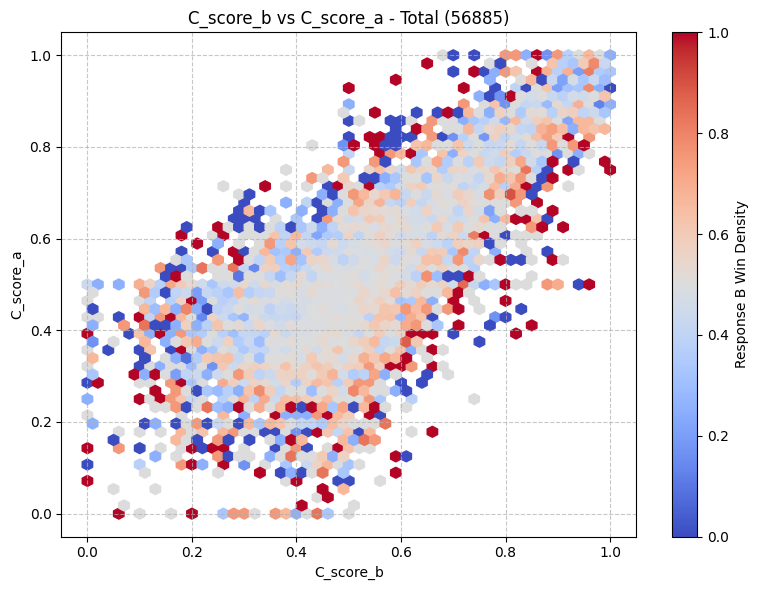

Regular questions (question-instruction). C scores are mildly correlated with user choice, specially in the extremes:


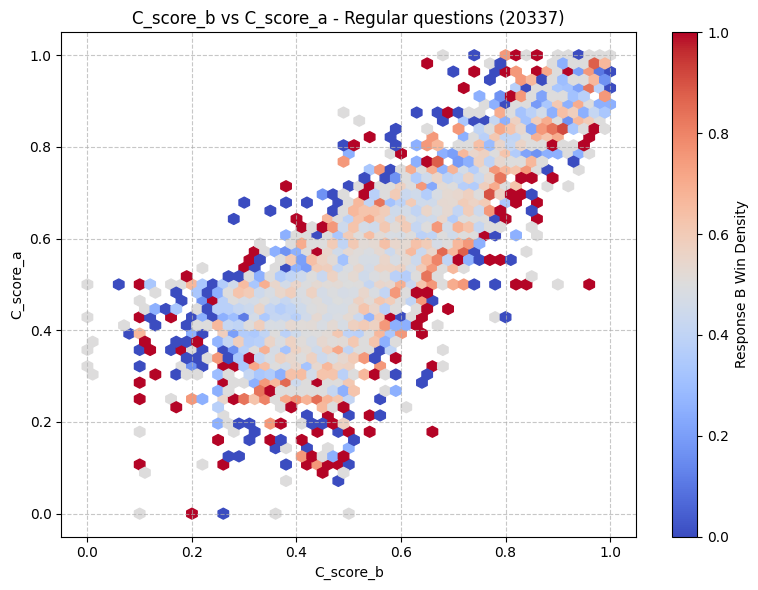

Trick questions (question-problem). C scores have higher predictive value in the mid-range


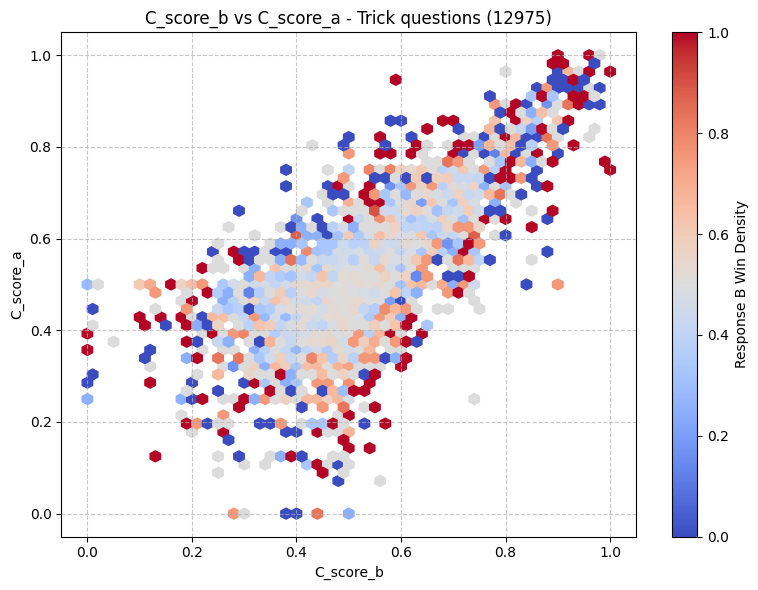

Regular requests (request-instruction). C scores have higher predictive value in the mid-range:


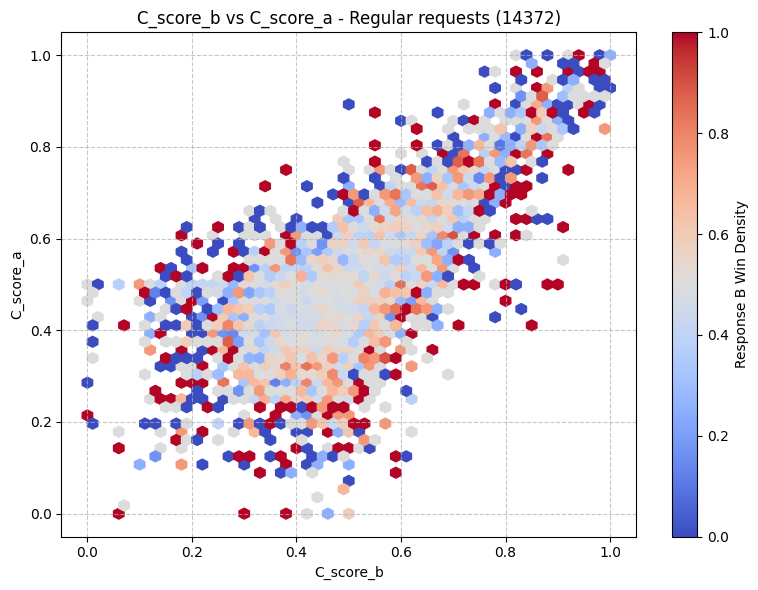

Problem-solving requests (request-problem). C scores have significantly lower predictive value:


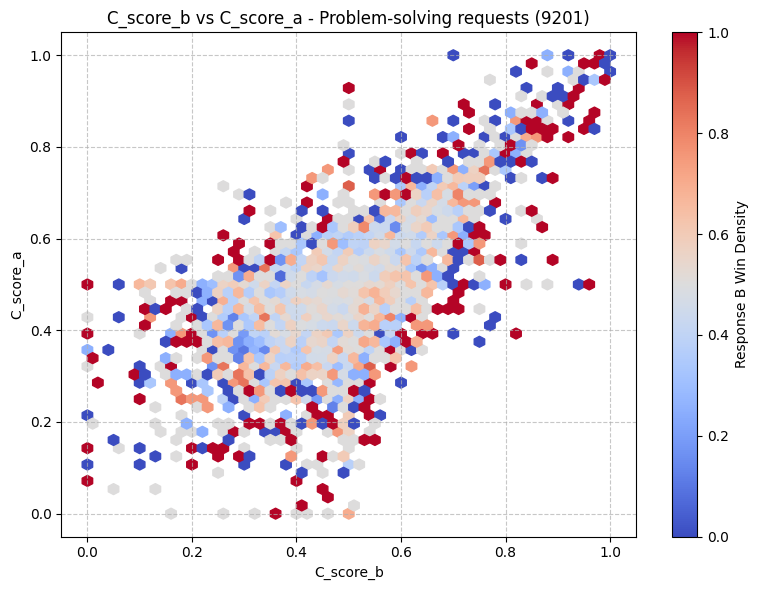

In [80]:
sampling = 1
resolution = 50
df_sample = df.sample(n=int(sampling*len(df)))
plot_hexbin(df_sample, 'C_score_a', 'C_score_b', title=f'Total ({df_sample.shape[0]})', gridsize=resolution)

print('Regular questions (question-instruction). C scores are mildly correlated with user choice, specially in the extremes:')
df_sample_qi = df_sample[(df_sample['label_rq'] == 'question') & (df_sample['label_tl'] == 'instruction')]
plot_hexbin(df_sample_qi, 'C_score_a', 'C_score_b', title=f'Regular questions ({df_sample_qi.shape[0]})', gridsize=resolution)

print('Trick questions (question-problem). C scores have higher predictive value in the mid-range')
df_sample_qp = df_sample[(df_sample['label_rq'] == 'question') & (df_sample['label_tl'] == 'problem')]
plot_hexbin(df_sample_qp, 'C_score_a', 'C_score_b', title=f'Trick questions ({df_sample_qp.shape[0]})', gridsize=resolution)

print('Regular requests (request-instruction). C scores have higher predictive value in the mid-range:')
df_sample_ri = df_sample[(df_sample['label_rq'] == 'request') & (df_sample['label_tl'] == 'instruction')]
plot_hexbin(df_sample_ri, 'C_score_a', 'C_score_b', title=f'Regular requests ({df_sample_ri.shape[0]})', gridsize=resolution)

print('Problem-solving requests (request-problem). C scores have significantly lower predictive value:')
df_sample_rp = df_sample[(df_sample['label_rq'] == 'request') & (df_sample['label_tl'] == 'problem')]
plot_hexbin(df_sample_rp, 'C_score_a', 'C_score_b', title=f'Problem-solving requests ({df_sample_rp.shape[0]})', gridsize=resolution)

# 7. Token length features (⌛ Brevity Score)

#### Tokenization example

In [81]:
tok_model_path = "reddgr/rq-request-question-prompt-classifier"

tokenizer = AutoTokenizer.from_pretrained(tok_model_path)
sentence = "The quick brown fox jumps over the lazy dog"
tokens = tokenizer(sentence)
print("Tokens:", tokens)
decoded_tokens = [tokenizer.decode([token]) for token in tokens['input_ids']]
print("Decoded Tokens:", decoded_tokens)
print(len(decoded_tokens))
print(len(sentence))

Tokens: {'input_ids': [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Decoded Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '[SEP]']
11
43


#### Example from dataset: great disparity in responses token counts

In [82]:
example1 = df.loc[df['id'] == 1658663803, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
print(f'Notice max. length of tokenizer is {tokenizer.model_max_length}, so we will longer texts')
print(f"Prompt ({len(example1[0])} characters): {example1[0]}")
p_tokens = tokenizer(example1[0])
decoded_tokens = [tokenizer.decode([token]) for token in p_tokens['input_ids']]
print(f"{len(decoded_tokens)} tokens in prompt ({len(example1[0])/len(decoded_tokens):.2f} char/tok): {decoded_tokens}")
# Response A
print(f"Response A ({len(example1[1])} characters):\n{example1[1]}")
ra_tokens = tokenizer(example1[1])
decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]
print(f"### {len(decoded_tokens)} tokens in response A ({len(example1[1])/len(decoded_tokens):.2f} char/tok).###\n...\n")
# Response B
print(f"Response B ({len(example1[2])} characters):\n{example1[2]}")
ra_tokens = tokenizer(example1[2])
decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]
print(f"###{len(decoded_tokens)} tokens in response B ({len(example1[2])/len(decoded_tokens):.2f} char/tok).###")

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


Notice max. length of tokenizer is 512, so we will longer texts
Prompt (30 characters): Why is trump a good president?
9 tokens in prompt (3.33 char/tok): ['[CLS]', 'why', 'is', 'trump', 'a', 'good', 'president', '?', '[SEP]']
Response A (358 characters):
As an AI, I don't have personal opinions. However, some people believe that President Trump has been a good president due to his efforts to improve the economy, his focus on job creation, and his support for certain policies such as tax cuts and deregulation. It's important to consider a wide range of perspectives when evaluating a president's performance.
### 76 tokens in response A (4.71 char/tok).###
...

Response B (2905 characters):
The perception of whether Donald Trump was a good president varies widely and is often influenced by individual political beliefs, values, and priorities. Those who view him as a good president often cite the following reasons:

1. Economic Performance: Under Trump's administration, the United States 

#### Example from dataset: low character/token ratio (technical and software programming questions)

In [83]:
example2 = df.loc[df['id'] == 856286322, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
print(f"Prompt ({len(example2[0])} characters):\n {example2[0][:150]}\n[...]") # we just show the first 150 characters
p_tokens = tokenizer(example2[0])
decoded_tokens = [tokenizer.decode([token]) for token in p_tokens['input_ids']]
print(f"{len(decoded_tokens)} tokens in prompt ({len(example2[0])/len(decoded_tokens):.2f} char/tok).")
# Response A
print(f"\nResponse A ({len(example2[1])} characters):\n{example2[1][:150]}\n[...]")
ra_tokens = tokenizer(example2[1])
decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]
print(f"{len(decoded_tokens)} tokens in response A ({len(example2[1])/len(decoded_tokens):.2f} char/tok).")
# Response B
print(f"\nResponse B ({len(example2[2])} characters):\n{example2[2][:150]}\n[...]")
ra_tokens = tokenizer(example2[2])
decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]
print(f"{len(decoded_tokens)} tokens in response B ({len(example2[1])/len(decoded_tokens):.2f} char/tok).")

Prompt (1523 characters):
 def author_generator(self):
redis_keys = self.redit_inst.keys('*')
for key in redis_keys:
        key_description = self.redit_inst.get(key).decode('u
[...]
550 tokens in prompt (2.77 char/tok).

Response A (876 characters):
You can apply PCA after you have generated the author embeddings. Here is where you would add it:

```python
author_embeddings = []
for i, x in enumer
[...]
262 tokens in response A (3.34 char/tok).

Response B (2521 characters):
Principal Component Analysis (PCA) is a dimensionality reduction technique that is often used to reduce the dimensionality of large datasets, increasi
[...]
675 tokens in response B (1.30 char/tok).


### Token metrics calculations

See notebook lmsys-cba-reddgr-scbn-rqtl-kaggle.ipynb. The dataset loaded in this notebook contains all calculated metrics.

#### Metrics examples

In [84]:
tok_metrics_examples = df_features.sample(n=1)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
display(tok_metrics_examples[['prompt', 'p_len', 'p_tc', 'p_chtk_ratio']])
display(tok_metrics_examples[['response_a', 'ra_len', 'ra_tc', 'ra_chtk_ratio']])
display(tok_metrics_examples[['response_b', 'rb_len', 'rb_tc', 'rb_chtk_ratio']])
pd.reset_option('display.float_format')

prompt  p_len  p_tc  \
44782  A metaphor is like a hidden map; it takes you ... 137.00 32.00   

       p_chtk_ratio  
44782          4.57

response_a  ra_len  ra_tc  \
44782  Certainly! A metaphor for the concept of 'hope...  459.00  97.00   

       ra_chtk_ratio  
44782           4.83

response_b  rb_len  rb_tc  \
44782  Hope is a gentle breeze that whispers promises...  126.00  24.00   

       rb_chtk_ratio  
44782           5.72

### Calculate Brevity score:

See notebook lmsys-cba-reddgr-scbn-rqtl-kaggle.ipynb. The dataset loaded in this notebook contains all calculated metrics.

### Histograms for ⌛ Brevity Score

Average Relative Brevity Score (winner vs loser): 0.0304


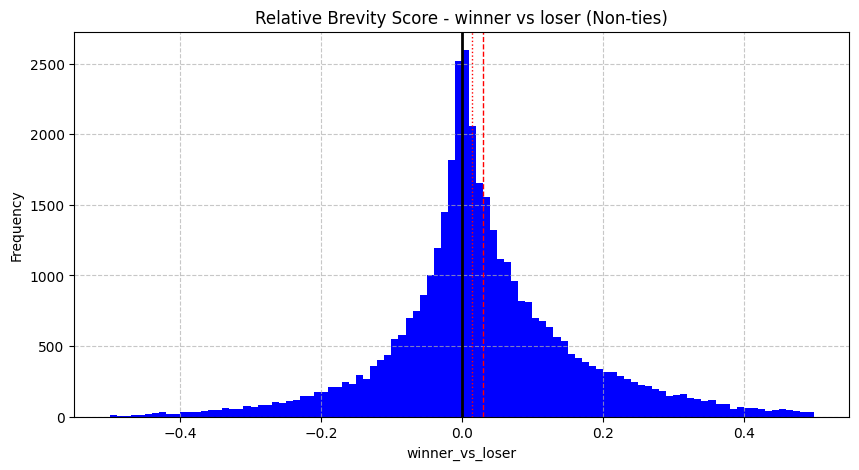

Average Relative Brevity Score (Model A wins): 0.0330


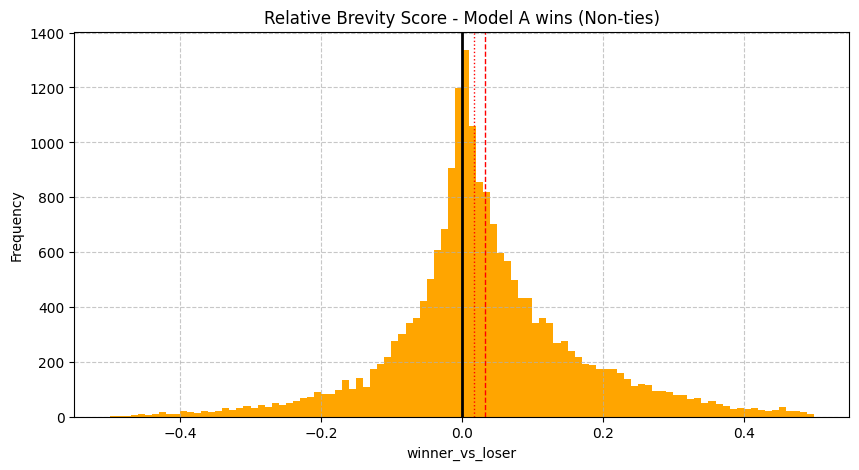

Average Relative Brevity Score (Model B wins): 0.0277


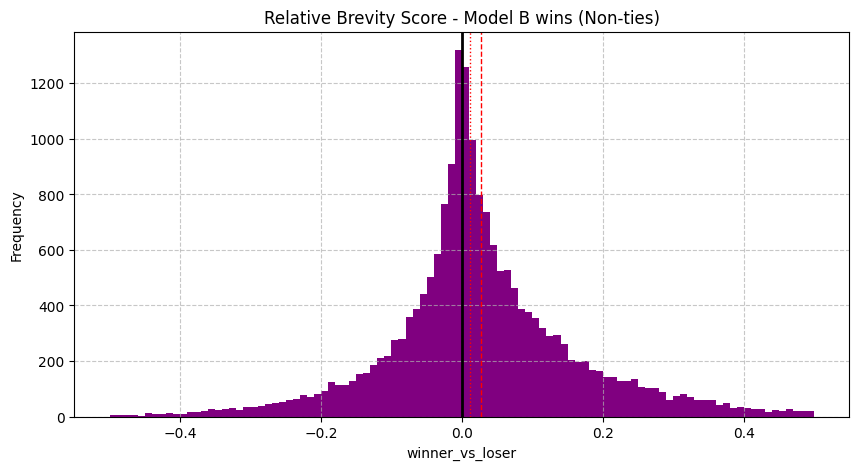

Average Relative Brevity Score (ties): -0.0027


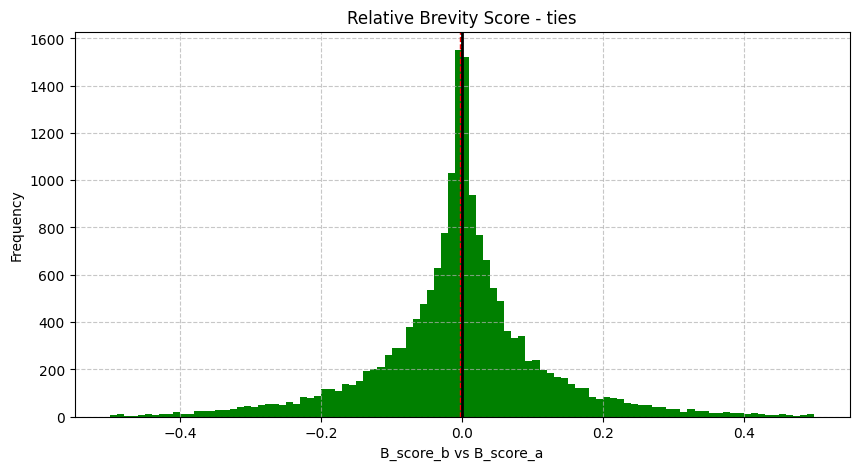

In [85]:
hist_feature_diff(df, 'B_score_a', 'B_score_b', "Relative Brevity Score", range_min=-0.5, range_max=0.5, nbins=100)

### Hexbin plots for ⌛ Brevity Score

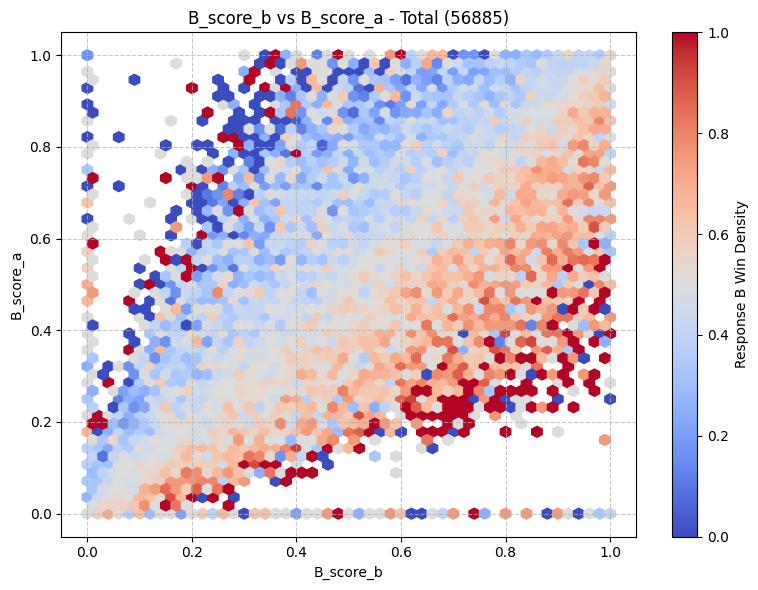

In [86]:
resolution = 50
plot_hexbin(df, 'B_score_a', 'B_score_b', title=f'Total ({df.shape[0]})', gridsize=resolution)

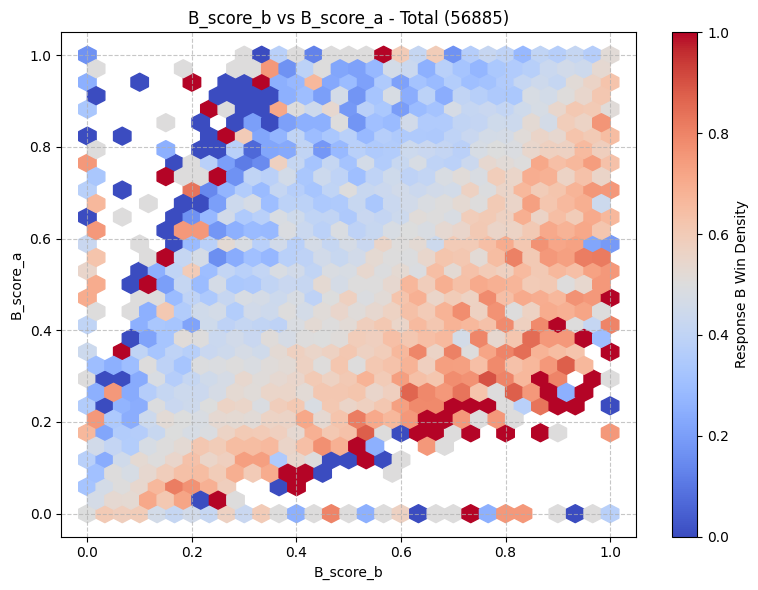

Regular questions (question-instruction). B scores are highly correlated with user choice:


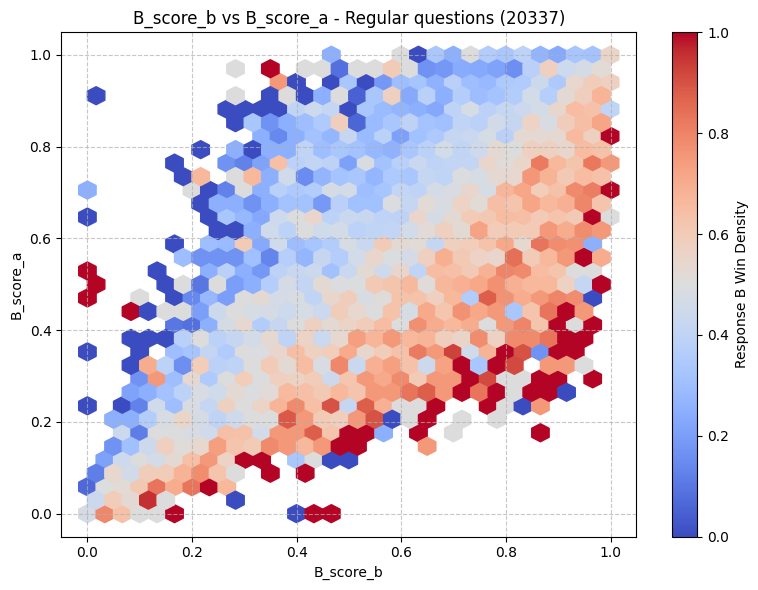

Trick questions (question-problem). B scores are mildly correlated with user choice, specially in the extremes


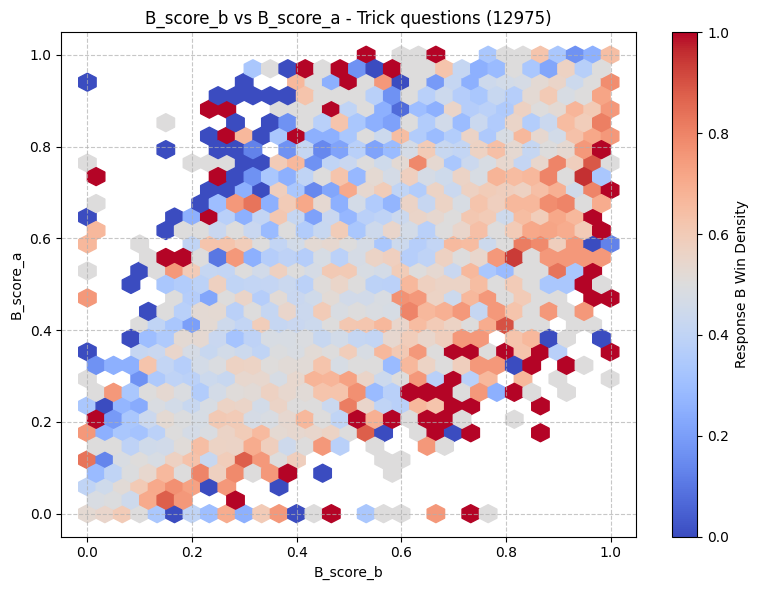

Regular requests (request-instruction). B scores have the higher predictive value in the extremes:


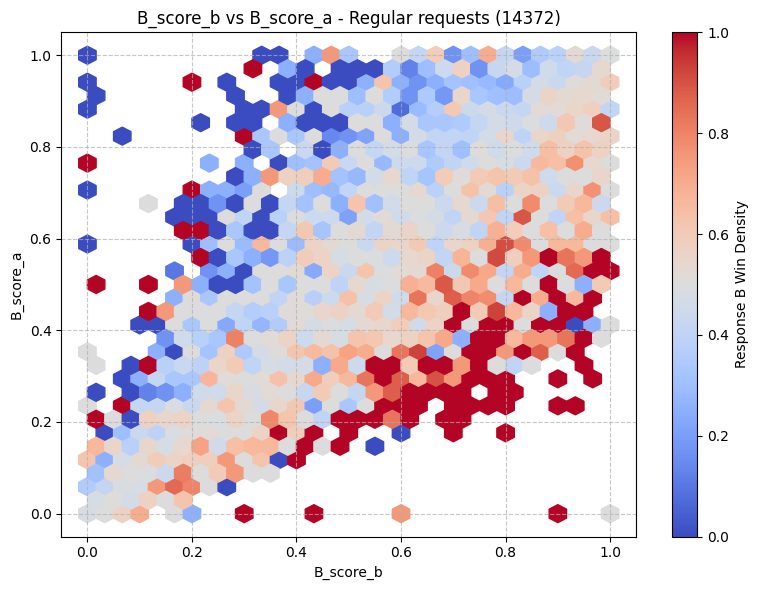

Problem-solving requests (request-problem). B scores have the lowest predictive value for this category of prompts:


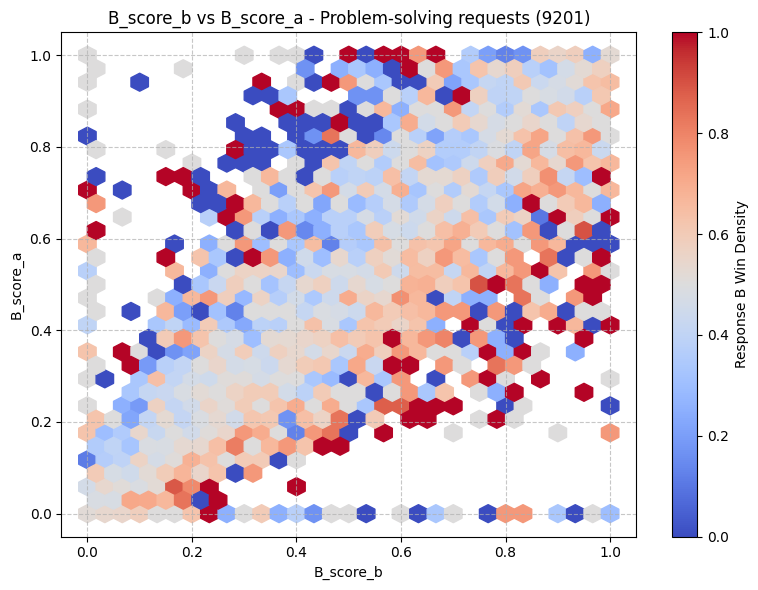

In [87]:
resolution = 30
plot_hexbin(df, 'B_score_a', 'B_score_b', title=f'Total ({df.shape[0]})', gridsize=resolution)

print('Regular questions (question-instruction). B scores are highly correlated with user choice:')
df_qi = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_qi, 'B_score_a', 'B_score_b', title=f'Regular questions ({df_qi.shape[0]})', gridsize=resolution)

print('Trick questions (question-problem). B scores are mildly correlated with user choice, specially in the extremes')
df_qp = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'problem')]
plot_hexbin(df_qp, 'B_score_a', 'B_score_b', title=f'Trick questions ({df_qp.shape[0]})', gridsize=resolution)

print('Regular requests (request-instruction). B scores have the higher predictive value in the extremes:')
df_ri = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_ri, 'B_score_a', 'B_score_b', title=f'Regular requests ({df_ri.shape[0]})', gridsize=resolution)

print('Problem-solving requests (request-problem). B scores have the lowest predictive value for this category of prompts:')
df_rp = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'problem')]
plot_hexbin(df_rp, 'B_score_a', 'B_score_b', title=f'Problem-solving requests ({df_rp.shape[0]})', gridsize=resolution)

### 🎯🧩⌛💡 SCBN Scores

See notebook lmsys-cba-reddgr-scbn-rqtl-kaggle.ipynb for full metrics calculations process. The dataset loaded in this notebook contains all calculated metrics.

In [88]:
# df['SCBN_score_a'] = df['S_score_a'] + df['C_score_a'] + df['B_score_a'] + df['N_score_a']
# df['SCBN_score_b'] = df['S_score_b'] + df['C_score_b'] + df['B_score_b'] + df['N_score_b']
print(df.shape)

(56885, 56)


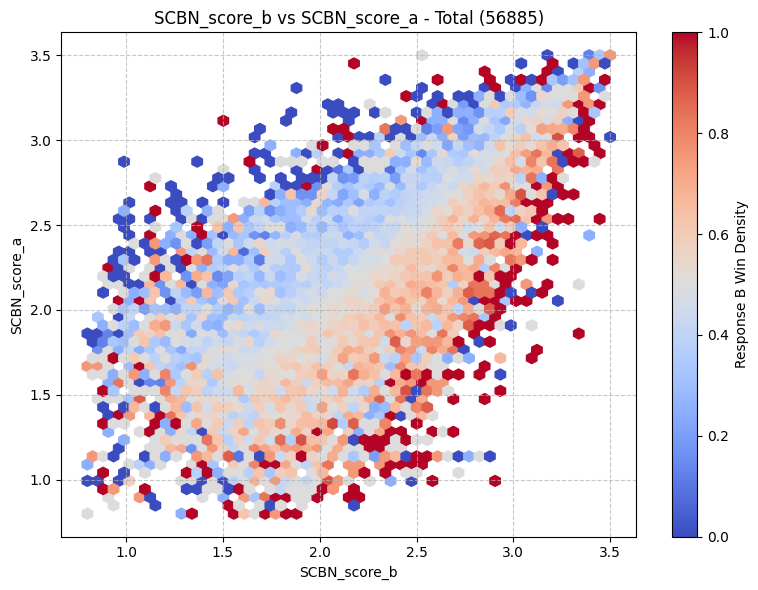

Regular questions (question-instruction). SCBN scores are highly correlated with user choice:


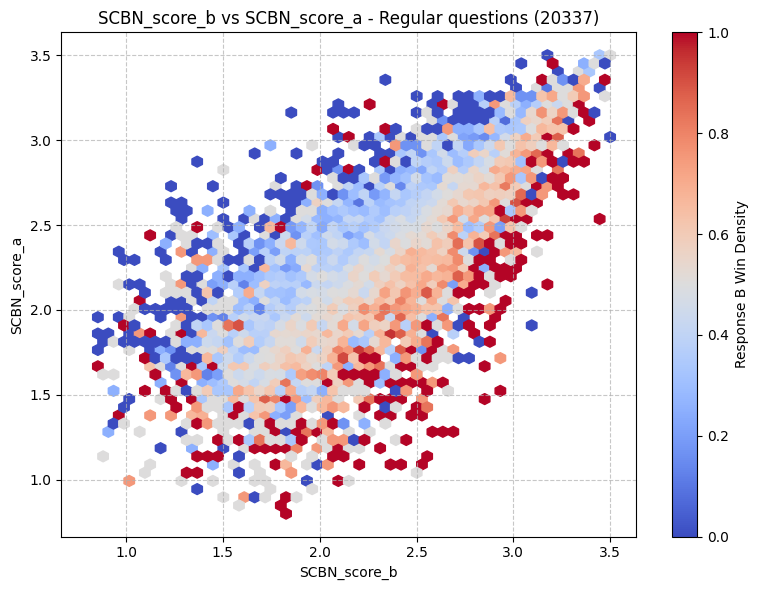

Trick questions (question-problem). SCBN scores are mildly correlated with user choice. 
S & C stronger in mid-range. B stronger in extremes:


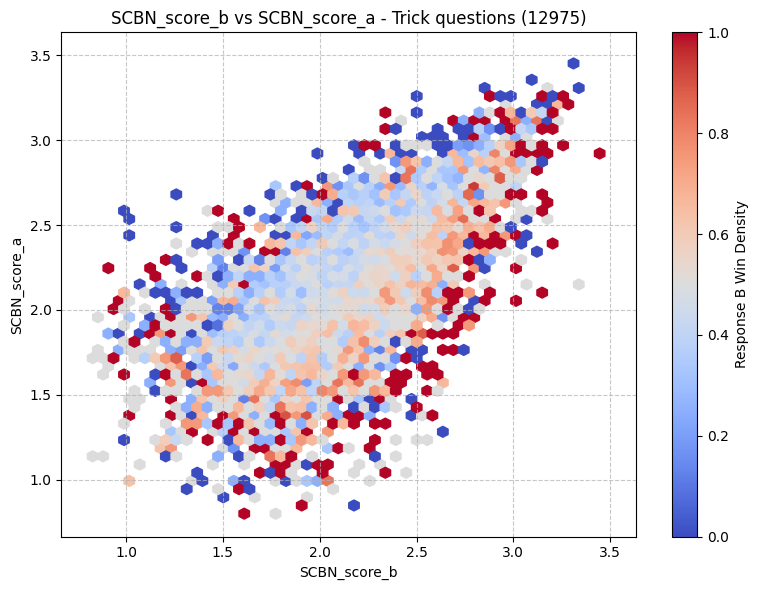

Regular requests (request-instruction). SCBN scores are mildly correlated with user choice.
N stronger in low-range, C mid-range, B extremes:


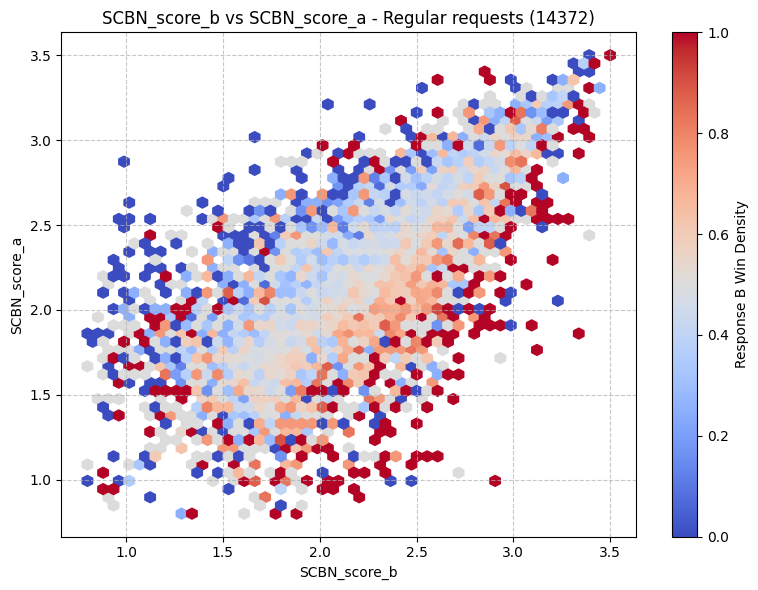

Problem-solving requests (request-problem). SCBN scores have the lowest predictive value.
S scores might be more significant than CBN:


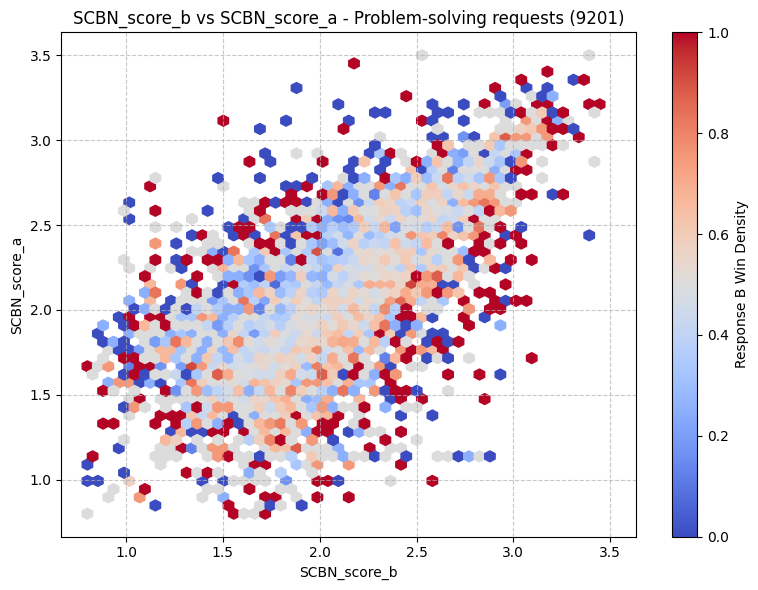

In [90]:
resolution = 50
plot_hexbin(df, 'SCBN_score_a', 'SCBN_score_b', title=f'Total ({df.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

print('Regular questions (question-instruction). SCBN scores are highly correlated with user choice:')
df_qi = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_qi, 'SCBN_score_a', 'SCBN_score_b', title=f'Regular questions ({df_qi.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

print('Trick questions (question-problem). SCBN scores are mildly correlated with user choice. \nS & C stronger in mid-range. B stronger in extremes:')
df_qp = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'problem')]
plot_hexbin(df_qp, 'SCBN_score_a', 'SCBN_score_b', title=f'Trick questions ({df_qp.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

print('Regular requests (request-instruction). SCBN scores are mildly correlated with user choice.\nN stronger in low-range, C mid-range, B extremes:')
df_ri = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_ri, 'SCBN_score_a', 'SCBN_score_b', title=f'Regular requests ({df_ri.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

print('Problem-solving requests (request-problem). SCBN scores have the lowest predictive value.\nS scores might be more significant than CBN:')
df_rp = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'problem')]
plot_hexbin(df_rp, 'SCBN_score_a', 'SCBN_score_b', title=f'Problem-solving requests ({df_rp.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

# 9. 📊 PCA and SCBN scores evaluation

In [91]:
print(df.shape)
print(df.columns)

(56885, 56)
Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie', 'class_name',
       'class_label', 'trimmed_prompt', 'label_rq', 'prob_rq', 'r_vs_q',
       'label_tl', 'prob_tl', 't_vs_l', 'tfidf_prompt', 'tfidf_ra', 'tfidf_rb',
       'N_score_a', 'N_score_b', 'pol_p', 'pol_ra', 'pol_rb', 'rel_pol_ra',
       'rel_pol_rb', 'subj_p', 'subj_ra', 'subj_rb', 'rel_subj_ra',
       'rel_subj_rb', 'S_score_a', 'S_score_b', 'C_score_a', 'C_score_b',
       'S_rel', 'C_rel', 'N_rel', 'p_len', 'ra_len', 'rb_len', 'p_tc', 'ra_tc',
       'rb_tc', 'p_chtk_ratio', 'ra_chtk_ratio', 'rb_chtk_ratio', 'B_score_a',
       'B_score_b', 'SCBN_score_a', 'SCBN_score_b', 'encode_fail', 'options',
       'winner_vs_loser'],
      dtype='object')


In [92]:
# Separate features and target
X = df[['r_vs_q', 't_vs_l', 'tfidf_prompt', 'tfidf_ra', 'tfidf_rb', 
        'rel_pol_ra', 'rel_pol_rb', 'rel_subj_ra', 'rel_subj_rb', 'S_score_a',
        'S_score_b', 'C_score_a', 'C_score_b', 'B_score_a', 'B_score_b', 'N_score_a', 'N_score_b', 
        'SCBN_score_a', 'SCBN_score_b', 'p_len', 'ra_len', 'rb_len', 'p_tc', 'ra_tc', 'rb_tc',
       'p_chtk_ratio', 'ra_chtk_ratio', 'rb_chtk_ratio']] # 'r_vs_q_u'
y = df['class_label']

# Handle NaN values by imputing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imputed)

# Perform PCA
pca = PCA(n_components=3)  # You can adjust the number of components based on your requirement
principal_components = pca.fit_transform(X_std)

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2', 'principal_component_3'])
df_pca['class_label'] = y.values

# Output feature influence
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
feature_influence = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=X.columns)

# Add column with the average of the absolute values of the principal components scores for each feature
feature_influence['average_abs_loading'] = feature_influence.apply(lambda row: np.mean(np.abs(row)), axis=1)
# feature_influence.sort_values(by="average_abs_loading", ascending=False)

feature_influence = feature_influence.sort_values(by="average_abs_loading", ascending=False)
print("Feature influence on the principal components with average absolute loading:")
print(feature_influence.sort_values(by="average_abs_loading", ascending=False))
print(feature_influence.index[:4])

Feature influence on the principal components with average absolute loading:
                    PC1       PC2       PC3  average_abs_loading
SCBN_score_b   0.644878  0.552637 -0.360253             0.519256
SCBN_score_a   0.648807  0.547736 -0.357501             0.518015
rel_subj_ra    0.530309 -0.549469  0.367884             0.482554
rel_subj_rb    0.530828 -0.551734  0.361456             0.481339
tfidf_prompt   0.708306 -0.264684 -0.451563             0.474851
ra_tc          0.258911  0.555439  0.574213             0.462854
rb_tc          0.258243  0.555059  0.572732             0.462011
ra_len         0.233988  0.557205  0.571037             0.454077
rb_len         0.228723  0.551264  0.569349             0.449779
S_score_a     -0.410484  0.696926 -0.229514             0.445641
S_score_b     -0.408386  0.699832 -0.227474             0.445231
C_score_b     -0.177998  0.647782 -0.460283             0.428687
C_score_a     -0.176847  0.645966 -0.459712             0.427509
p_tc         

# 🌱 Linear Decision Tree Model (first approximation and feature calibration)

With the calculated metrics, it's fairly easy to achieve higher than 40% accuracy on out-of-sample data with a decision tree classifier. Given that there are three fairly compensated classes, a "coin toss" approach would achieve 33.3% accuracy. This further proves the RQTL features and SCBN metrics are a good starting point to refine and incorporate to models that may add other additional approaches such as embeddings, vectorization of the prompt-responses sequences, LLM as judges, etc. In my opinion, all approaches that involve the use of LLMs for inference and classification beyond a simple theoretical scope such as the one used in this notebook might be good for achieving high scores on the Kaggle competition, but lack a practical purpose, considering the size of this competition's dataset is orders of magnitude smaller than that of any LLM, and considering the high cost (in processiong time) of inferences on a dataset like this. 

In [93]:
print(len(feature_influence.index))

28


In [94]:
feature_influence.index

Index(['SCBN_score_b', 'SCBN_score_a', 'rel_subj_ra', 'rel_subj_rb',
       'tfidf_prompt', 'ra_tc', 'rb_tc', 'ra_len', 'rb_len', 'S_score_a',
       'S_score_b', 'C_score_b', 'C_score_a', 'p_tc', 'tfidf_rb', 'tfidf_ra',
       'B_score_b', 'B_score_a', 'p_len', 'N_score_b', 'N_score_a',
       'rel_pol_rb', 'rel_pol_ra', 'p_chtk_ratio', 't_vs_l', 'r_vs_q',
       'ra_chtk_ratio', 'rb_chtk_ratio'],
      dtype='object')

In [95]:
def dtree_class(features, target, max_depth, min_samples_leaf=2, test_size=0.3, print_stats=True):
    X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size=test_size, 
                                                        stratify = target,
                                                        random_state=39)

    dTree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    dTree.fit(X_train, y_train)
    X_train_predictions = dTree.predict(X_train)
    X_test_predictions = dTree.predict(X_test)

    if print_stats:
        print("Train Metrics:")
        print(classification_report(y_train, X_train_predictions))
        print("Test Metrics:")
        print(classification_report(y_test, X_test_predictions))

    return dTree

features_list = feature_influence.index[:25].to_list()
features = df[features_list].fillna(0)
target = df['class_name']

dTree_3 = dtree_class(features, target, 10, 2, 0.2)

Train Metrics:
                precision    recall  f1-score   support

winner_model_a       0.50      0.60      0.55     15886
winner_model_b       0.55      0.48      0.51     15536
    winner_tie       0.48      0.44      0.46     14086

      accuracy                           0.51     45508
     macro avg       0.51      0.51      0.50     45508
  weighted avg       0.51      0.51      0.51     45508

Test Metrics:
                precision    recall  f1-score   support

winner_model_a       0.43      0.52      0.47      3971
winner_model_b       0.45      0.40      0.42      3884
    winner_tie       0.37      0.34      0.36      3522

      accuracy                           0.42     11377
     macro avg       0.42      0.42      0.42     11377
  weighted avg       0.42      0.42      0.42     11377



For illustrative purposes, we can calculate the probabilities on the Kaggle competition test file. An obvious approach for the competition would involve "fine-tuning" this notebook, the metrics and the trained models aiming at producing "reasonable" results for these particular cases (some of them are quite obvious to a human, such as the "trick question" about the oranges), but this notebook is not focused on competition scores.  

In [96]:
test_features = test_df[features_list].fillna(0)
# Get probabilities for all classes
probabilities_dtree = dTree_3.predict_proba(test_features)
# Create a dictionary to store probabilities for each class
class_probabilities = {}
# Extract probabilities for each class
for i, class_name in enumerate(dTree_3.classes_):
    class_probabilities[class_name] = probabilities_dtree[:, i]
# Now you can access probabilities for each class
prob_winner_model_a = class_probabilities['winner_model_a']
prob_winner_model_b = class_probabilities['winner_model_b']
prob_winner_tie = class_probabilities['winner_tie']
test_df['prob_winner_model_a'] = prob_winner_model_a
test_df['prob_winner_model_b'] = prob_winner_model_b
test_df['prob_winner_tie'] = prob_winner_tie
display(test_df[['id', 'prompt', 'response_a', 'response_b',
       'prob_winner_model_a', 'prob_winner_model_b', 'prob_winner_tie']])

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  prob_winner_model_a  \
0  You still have three oranges. Eating an orange...             0.531746   
1  Mr Reddy and Ms Blue both have valid points in...             0.638298   
2  To initialize the classification head when per...             0.000000   

   prob_winner_model_b  prob_winner_tie  
0             0.206349         0.261905  
1             0.148936         0.212766  
2             1.000000         0.000000

# Logistic regression

In [97]:
def train_logistic_regression(features, target, test_size=0.2, max_iter=100, solver='lbfgs', print_stats=True):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size,
                                                        stratify = target, random_state=42)

    log_reg = LogisticRegression(max_iter=max_iter, solver=solver)
    log_reg.fit(X_train, y_train)
    X_train_predictions = log_reg.predict(X_train)
    X_test_predictions = log_reg.predict(X_test)

    if print_stats:
        print("Train Metrics:")
        print(classification_report(y_train, X_train_predictions, target_names=log_reg.classes_, zero_division=0))
        print("Test Metrics:")
        print(classification_report(y_test, X_test_predictions, target_names=log_reg.classes_, zero_division=0))

    return log_reg

Training:

In [98]:
features_list = feature_influence.index[:25].to_list()
features = df[features_list].fillna(0)
target = df['class_name']
log_reg_model = train_logistic_regression(features, target, 0.3, 1000, 'lbfgs')

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Metrics:
                precision    recall  f1-score   support

winner_model_a       0.46      0.53      0.49     13900
winner_model_b       0.45      0.52      0.48     13594
    winner_tie       0.41      0.26      0.32     12325

      accuracy                           0.44     39819
     macro avg       0.44      0.44      0.43     39819
  weighted avg       0.44      0.44      0.43     39819

Test Metrics:
                precision    recall  f1-score   support

winner_model_a       0.46      0.53      0.49      5957
winner_model_b       0.45      0.51      0.48      5826
    winner_tie       0.40      0.26      0.32      5283

      accuracy                           0.44     17066
     macro avg       0.43      0.44      0.43     17066
  weighted avg       0.44      0.44      0.43     17066



Predictions:

In [99]:
test_features = test_df[features_list].fillna(0)
probabilities_lr = log_reg_model.predict_proba(test_features)
# Create a dictionary to store probabilities for each class
class_probabilities = {}
# Extract probabilities for each class
for i, class_name in enumerate(log_reg_model.classes_):
    class_probabilities[class_name] = probabilities_lr[:, i]
# Now we can access probabilities for each class
prob_winner_model_a = class_probabilities['winner_model_a']
prob_winner_model_b = class_probabilities['winner_model_b']
prob_winner_tie = class_probabilities['winner_tie']
test_df['prob_winner_model_a'] = prob_winner_model_a
test_df['prob_winner_model_b'] = prob_winner_model_b
test_df['prob_winner_tie'] = prob_winner_tie
display(test_df[['id', 'prompt', 'response_a', 'response_b',
       'prob_winner_model_a', 'prob_winner_model_b', 'prob_winner_tie']])

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  prob_winner_model_a  \
0  You still have three oranges. Eating an orange...             0.267934   
1  Mr Reddy and Ms Blue both have valid points in...             0.430991   
2  To initialize the classification head when per...             0.317571   

   prob_winner_model_b  prob_winner_tie  
0             0.318520         0.413546  
1             0.204310         0.364699  
2             0.449065         0.233365

# 🧠 Neural Network

The acuracy metrics are similar if we train a small neural network. It's expected that the neural network does not add value if we are only using numerical metrics. This model will be potentially be more useful if we add embeddings for the full data set or other non-numeric features obtained from LLMs or some other model we might use to enrich the dataset.

In [100]:
features_list = feature_influence.index[:25].to_list()
target_feature = ['class_label']
print(features_list)

['SCBN_score_b', 'SCBN_score_a', 'rel_subj_ra', 'rel_subj_rb', 'tfidf_prompt', 'ra_tc', 'rb_tc', 'ra_len', 'rb_len', 'S_score_a', 'S_score_b', 'C_score_b', 'C_score_a', 'p_tc', 'tfidf_rb', 'tfidf_ra', 'B_score_b', 'B_score_a', 'p_len', 'N_score_b', 'N_score_a', 'rel_pol_rb', 'rel_pol_ra', 'p_chtk_ratio', 't_vs_l']


In [101]:
df.fillna(0, inplace=True)
train_df, valid_df = train_test_split(df, test_size=0.3, stratify=df["class_label"], random_state=37)
print('train_df', train_df.shape)
print('valid_df', valid_df.shape)
X_train = train_df[features_list]
y_train = train_df[target_feature]
X_test = valid_df[features_list]
y_test = valid_df[target_feature]
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

train_df (39819, 56)
valid_df (17066, 56)
X_train (39819, 25)
y_train (39819, 1)
X_test (17066, 25)
y_test (17066, 1)


In [102]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())
y_test_encoded = label_encoder.transform(y_test.values.ravel())

In [103]:
def configura_modelo(X_train, nn_oculta, nn_oculta2, l1reg=0, l2reg=0, dropout=None, act_1='relu', act_2='relu', act_output='softmax'):
    n_metricas = X_train.shape[1]
    inputs = keras.Input(shape=(n_metricas,), name="input")
    x = keras.layers.Dense(nn_oculta, activation = act_1,
                           kernel_regularizer=keras.regularizers.l1_l2(l1=l1reg, l2=l2reg), name="oculta")(inputs)
    if dropout: x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(nn_oculta2, activation = act_2,
                           kernel_regularizer=keras.regularizers.l1_l2(l1=l1reg, l2=l2reg), name="oculta2")(x)
    outputs = keras.layers.Dense(3, activation=act_output, name="output")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = configura_modelo(X_train_scaled, 50, 50)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 25)]              0         
                                                                 
 oculta (Dense)              (None, 50)                1300      
                                                                 
 oculta2 (Dense)             (None, 50)                2550      
                                                                 
 output (Dense)              (None, 3)                 153       
                                                                 
Total params: 4003 (15.64 KB)
Trainable params: 4003 (15.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [104]:
def entrenamiento(model, X_train, y_train, X_test, y_test, nepochs=100, bsize=20, optimizer_name='adam', lr=0.001, callbacks = None):
    if optimizer_name is not None:
        optimizer = keras.optimizers.get(optimizer_name)
        optimizer.learning_rate = lr
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', #
                  metrics=['acc'])

    history = model.fit(X_train,
                        y_train,
                        epochs=nepochs,
                        batch_size=bsize,
                        validation_data=(X_test, y_test),
                        callbacks = callbacks)
    return history

def plot_metrics(history, nepochs):
    hd = history.history
    epochs = range(1, nepochs+1)
    plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    plt.plot(epochs, hd['acc'], "r", label="train")
    plt.plot(epochs, hd['val_acc'], "b", label="test")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, hd['loss'], "r", label="train")
    plt.plot(epochs, hd['val_loss'], "b", label="test")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss (sparse categorical crossentropy)")
    plt.legend()
    plt.show()

Epoch 1/8
1991/1991 [==============================] - 3s 1ms/step - loss: 1.2208 - acc: 0.4310 - val_loss: 1.1479 - val_acc: 0.4348
Epoch 2/8
1991/1991 [==============================] - 2s 1ms/step - loss: 1.1106 - acc: 0.4435 - val_loss: 1.0870 - val_acc: 0.4428
Epoch 3/8
1991/1991 [==============================] - 2s 1ms/step - loss: 1.0778 - acc: 0.4449 - val_loss: 1.0723 - val_acc: 0.4413
Epoch 4/8
1991/1991 [==============================] - 2s 1ms/step - loss: 1.0696 - acc: 0.4460 - val_loss: 1.0672 - val_acc: 0.4464
Epoch 5/8
1991/1991 [==============================] - 2s 1ms/step - loss: 1.0667 - acc: 0.4461 - val_loss: 1.0644 - val_acc: 0.4432
Epoch 6/8
1991/1991 [==============================] - 2s 1ms/step - loss: 1.0647 - acc: 0.4454 - val_loss: 1.0633 - val_acc: 0.4455
Epoch 7/8
1991/1991 [==============================] - 2s 1ms/step - loss: 1.0634 - acc: 0.4487 - val_loss: 1.0632 - val_acc: 0.4452
Epoch 8/8
534/534 [==============================] - 0s 750us/step - 

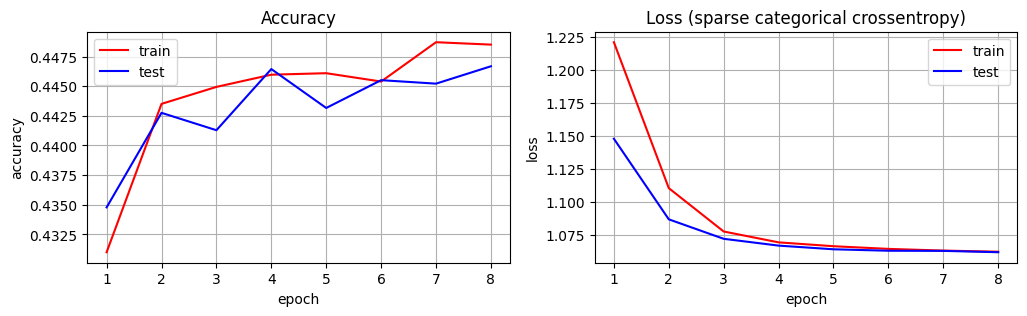

Features: 25


In [105]:
nepochs= 8
bsize = 20
lr = 0.0001
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_delta=0.1, min_lr=0.0001)
# early_stopping = EarlyStopping(monitor='loss', patience=6, min_delta=0.01, restore_best_weights=True)
optimizer_name= 'adam'
# model = configura_modelo(X_train, 30, 30, 'gelu', 'relu', 'softmax')
model = configura_modelo(X_train_scaled, 50, 50, l1reg=0.0005, l2reg=0, dropout=0.001)
history = entrenamiento (model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
                         nepochs, bsize, optimizer_name, callbacks=None)
loss_test, acc_test = model.evaluate(X_test_scaled, y_test_encoded)
print("Val. Loss: %f" % (loss_test))
print("Val. Accuracy: %f" % (acc_test))
plot_metrics(history, nepochs)
print(f'Features: {X_train_scaled.shape[1]}')

In [106]:
test_features = test_df[features_list].fillna(0)
probabilities_nn = model.predict(test_features)
class_probabilities = {}
class_names = ['winner_model_a', 'winner_model_b', 'winner_tie']
for i, class_name in enumerate(class_names):
    class_probabilities[class_name] = probabilities_nn[:, i]

prob_winner_model_a = class_probabilities['winner_model_a']
prob_winner_model_b = class_probabilities['winner_model_b']
prob_winner_tie = class_probabilities['winner_tie']

test_df['prob_winner_model_a'] = prob_winner_model_a
test_df['prob_winner_model_b'] = prob_winner_model_b
test_df['prob_winner_tie'] = prob_winner_tie

pd.options.display.float_format = '{:.3f}'.format
display(test_df[['id', 'prompt', 'response_a', 'response_b',
                 'prob_winner_model_a', 'prob_winner_model_b', 'prob_winner_tie']])
pd.reset_option('display.float_format')

1/1 [==============================] - 0s 57ms/step


id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  prob_winner_model_a  \
0  You still have three oranges. Eating an orange...                0.000   
1  Mr Reddy and Ms Blue both have valid points in...                1.000   
2  To initialize the classification head when per...                0.000   

   prob_winner_model_b  prob_winner_tie  
0                1.000            0.000  
1                0.000            0.000  
2                1.000            0.000